# Apresentação

Este trabalho tem como proposta a utilização de arquiteturas CNN para a resolução de problemas de classificação de imagens.

## Dataset
Escolhemos o dataset [**Sentinel-2 Land Cover Dataset**](https://www.kaggle.com/datasets/salmaadell/eurosat-rgb/data) para a tarefa de classificação multiclasse.


In [ ]:
import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

import torchvision
from torchsummary import summary
import torchvision.transforms.v2 as transforms
from torchvision import datasets

import os

In [3]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        
        # Input: 3 channels x 64x64
        # Feature map sequence: 3 → 16 → 32 channels
        # Why double channel numbers at each Conv Block?
        # Progressive feature learning
        # Conv Block 1 learns basic patterns
        # Conv Block 2 learns more complex patterns
        self.features = nn.Sequential(
            # Conv Block 1 (64x64 -> 32x32)
            # in_channels, out_channels, kernel_size, stride=1
            nn.Conv2d(3, 16, 3, padding=1),  # Preserve spatial dimensions
            nn.BatchNorm2d(16),               # stabilise training
            nn.ReLU(),                        # relu activation - avoid vanishing gradients
            # kernel_size=2
            # Why perform pooling - decrease spatial dimensions/computations, increase 'receptive field'
            nn.MaxPool2d(2),
            # output from Conv Block 1: 16 channels x 32x32


            # Conv Block 2 (32x32 -> 16x16)
            nn.Conv2d(16, 32, 3, padding=1),
            # From Conv2d: 32 channels x 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Output from Conv Block 2: 16x16x32

            
            # Additional pooling to reduce dimensions further
            # New layer to standardise output size
            nn.AdaptiveAvgPool2d((16, 16))
        )
        

        self.classifier = nn.Sequential(
            nn.Flatten(),                     # Prepare for FC layers
            nn.Linear(32*16*16, 256),         # Reduced feature dimension
            nn.Dropout(0.5),                  # Regularization
            nn.Linear(256, 10),
            # nn.Sigmoid()                      # Binary classification output
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Train Classifier

In [4]:
class Trainer:
    """
    Class to train and evaluate a PyTorch model with early stopping and metric tracking.
    """
    def __init__(self, model, dataloader={"train": [], "val": [], "test": []}, epochs=20, criterion=None, optimizer=None, learning_rate=1e-5, gradual_unfreeze=False, unfreeze_epoch=5, device=None, patience=3, class_names=[], best_model_path="./best_model", best_model_filename="best_model.pth"):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = model
        self.model.to(self.device)
        
        # Dataloaders
        self.dataloader = dataloader

        sample_batch = next(iter(self.dataloader["train"]))
        sample_labels = sample_batch[1]
        
        self.unique_labels = torch.unique(sample_labels)
        self.num_classes = len(self.unique_labels)
        self.class_names = class_names

        if self.num_classes == 2:
            self.criterion = torch.nn.BCEWithLogitsLoss() if criterion is None else criterion
        else:
            self.criterion = torch.nn.CrossEntropyLoss() if criterion is None else criterion

        print(f"Number of classes: {self.num_classes}")
        print(f"Using loss function: {self.criterion.__class__.__name__}")
        
        self.learning_rate = learning_rate
        self.optimizer = optimizer if optimizer else torch.optim.AdamW(self.model.parameters(), 
                                                                    lr=self.learning_rate, 
                                                                    weight_decay=1e-2)
        # Early stopping
        self.patience = patience
        
        self.gradual_unfreeze = gradual_unfreeze
        self.unfreeze_epoch = unfreeze_epoch
        
        if self.gradual_unfreeze:
            # Freeze all layers except the last one
            for param in self.model.parameters():
                param.requires_grad = False
            # Unfreeze the last layer
            if hasattr(self.model, 'classifier'):
                for param in self.model.classifier.parameters():  # Assuming the last layer is named 'classifier'
                    param.requires_grad = True
            elif hasattr(self.model, 'fc'):
                for param in self.model.fc.parameters():
                    param.requires_grad = True
            else:
                raise ValueError("Model does not have a 'classifier' or 'fc' attribute.")

            # Update optimizer to only include parameters that require gradients
            self.optimizer = optimizer if optimizer else torch.optim.AdamW(
                filter(lambda p: p.requires_grad, self.model.parameters()),
                lr=self.learning_rate,
                weight_decay=1e-2
            )
        
        # metrics history
        self.history = {
            "train_loss": [], "val_loss": [],
            "train_acc": [], "val_acc": [],
            "train_f1": [], "val_f1": [],
            "train_precision": [], "val_precision": [],
            "train_recall": [], "val_recall": []
        }
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0

        self.epochs = epochs
        self.best_model_path = best_model_path
        self.best_model_filename = best_model_filename


    def check_early_stopping(self, val_loss):
        eps = 0.01 # 1% val loss improvement required
        improvement = 0.0
        
        # First epoch
        if self.best_val_loss == float('inf'):
            best_loss = val_loss
            improvement = 1.0  # 100% improvement from infinity
        # subsequent epochs
        else:
            improvement = (self.best_val_loss - val_loss) / self.best_val_loss
            
        # Check if validation loss improved
        if improvement > eps:
            print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Save the best model
            self.best_val_loss = val_loss
            self.early_stop_counter = 0
            self.save_best_model()
        else:
            print(f"Validation loss did not improve from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Increment early stop counter
            self.early_stop_counter += 1
            print(f"Early stop counter: {self.early_stop_counter}/{self.patience}")
            if self.early_stop_counter >= self.patience:
                return True
        return False


    def save_best_model(self):
        os.makedirs(self.best_model_path, exist_ok=True)
        model_path = os.path.join(self.best_model_path, self.best_model_filename)
        torch.save(self.model.state_dict(), model_path)
        print(f"Best model saved to {model_path}")


    def fit(self):
        for epoch in range(self.epochs):
            if self.gradual_unfreeze and epoch == self.unfreeze_epoch:
                print("Unfreezing all layers...")
                for param in self.model.parameters():
                    param.requires_grad = True
                # Update optimizer to include all parameters
                self.optimizer = torch.optim.AdamW(
                    self.model.parameters(),
                    lr=self.learning_rate,
                    weight_decay=1e-2
                )
            _ = self.train_epoch(epoch)
            history = self.evaluate()

            if self.check_early_stopping(history['loss']):
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break


    def train_epoch(self, epoch, train=True, testing=False):
        """
        Train the model for one epoch.
        """
        
        phase = "train" if train else "val" if not testing else "test"

        if train:
            self.model.train()
        else:
            self.model.eval()
            
        losses = []
        all_predictions = []
        all_labels = []
        
        bar = tqdm.tqdm(self.dataloader[phase], desc=f"{phase.capitalize()} Epoch {epoch+1 }/{self.epochs}", unit="batch")
        for index, pack in enumerate(bar):
            # Unpack the batch
            x, labels = pack
            x = x.to(self.device)
            labels = labels.to(self.device)
            
            # Convert labels to float and set to 1.0 (all samples are positive class)
            if self.num_classes == 2:
                labels = labels.float()
                labels = torch.ones_like(labels)
            else:
                labels = labels.squeeze()
            self.optimizer.zero_grad()
            
            # Forward pass
            # Use torch.set_grad_enabled to enable/disable gradient calculation
            with torch.set_grad_enabled(train):
                logits = self.model(x).squeeze(1)
                if self.num_classes == 2:
                    # Binary classification
                    labels = labels.float()
                    loss = self.criterion(logits, labels)
                    prediction = torch.sigmoid(logits).detach().cpu().numpy().round()
                else:
                    # Multi-class classification
                    labels = labels.squeeze()
                    loss = self.criterion(logits, labels)
                    prediction = torch.argmax(logits, 1).detach().cpu().numpy()
                
            # Backward pass and optimization
            if phase == 'train':
                loss.backward()
                self.optimizer.step()

            # Store predictions
            losses.append(loss.item())
        
            true_labels = labels.cpu().numpy()
        
            # Save predictions and labels
            all_predictions.extend(prediction)
            all_labels.extend(true_labels)
            if index % 10 == 0:
                bar.set_postfix(loss=np.mean(losses))

        history = self.compute_metrics(all_predictions, all_labels)
        history['loss'] = np.mean(losses)
        
        # Save metrics to history
        if train:
            self.update_history(history, train=True)
            print(f"Epoch {epoch+1} - Train Loss: {np.mean(losses):.4f} - Train Accuracy: {history['accuracy']:.4f} - Train F1: {history['f1']:.4f} - Train Precision: {history['precision']:.4f} - Train Recall: {history['recall']:.4f}")
        elif not testing:
            # Validation
            self.update_history(history, train=False)
            print(f"Epoch {epoch+1} - Val Loss: {np.mean(losses):.4f} - Val Accuracy: {history['accuracy']:.4f} - Val F1: {history['f1']:.4f} - Val Precision: {history['precision']:.4f} - Val Recall: {history['recall']:.4f}")
        return history
    

    def test(self):
        """
        Evaluate the model on the test set.
        """
        return self.train_epoch(0, train=False, testing=True)


    def evaluate(self, testing=False):
        """
        Evaluate the model on the validation set.
        """
        return self.train_epoch(0, train=False, testing=testing)


    def predict(self, x):
        """
        Predict the class of the input data.
        """
        self.model.eval()
        x = x.to(self.device)
        
        with torch.no_grad():
            logits = self.model(x).squeeze(1)
            if self.num_classes == 2:
                prediction = torch.sigmoid(logits).detach().cpu().numpy().round()
            else:
                prediction = torch.argmax(logits, 1).detach().cpu().numpy()
        
        return prediction


    def update_history(self, history, train=True):
        prefix = "train" if train else "val"
        self.history[f"{prefix}_loss"].append(history['loss'])
        self.history[f"{prefix}_acc"].append(history['accuracy'])
        self.history[f"{prefix}_precision"].append(history['precision'])
        self.history[f"{prefix}_recall"].append(history['recall'])
        self.history[f"{prefix}_f1"].append(history['f1'])


    def compute_metrics(self, predictions, labels):
        predictions = np.array(predictions)
        labels = np.array(labels)
        
        average = 'binary' if self.num_classes == 2 else 'weighted'
        return {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average=average, zero_division=0),
            "precision": precision_score(labels, predictions, average=average, zero_division=0),
            "recall": recall_score(labels, predictions, average=average, zero_division=0),
            "confusion_matrix": confusion_matrix(labels, predictions)
        }
        

    def plot_metrics(self, history=None, title="Training and Validation Metrics"):
        """
        Plot the training and validation metrics.
        """
        if not history:
            history = self.history
        epochs = range(1, len(history['train_loss']) + 1)
        
        plt.figure(figsize=(20, 8))
        
        # Plotting Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
        plt.title('Train and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plotting all other metrics
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
        plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
        plt.plot(epochs, history['train_precision'], 'b--', label='Train Precision')
        plt.plot(epochs, history['val_precision'], 'r--', label='Validation Precision')
        plt.plot(epochs, history['train_recall'], 'b-.', label='Train Recall')
        plt.plot(epochs, history['val_recall'], 'r-.', label='Validation Recall')
        plt.plot(epochs, history['train_f1'], 'b:', label=
                 'Train F1')
        plt.plot(epochs, history['val_f1'], 'r:', label='Validation F1')
        plt.title('Train and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.suptitle(title)
        
        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, cm=None, class_names=None):
        """
        Plot the confusion matrix.
        """
        if cm is None:
            cm = self.history['confusion_matrix']
        if class_names is None:
            class_names = self.class_names
            
        # Normalize the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

# Prepare Dataset

In [88]:
n_annualcrop = 0
n_highway = 0
dataset_path = '/kaggle/input/eurosat-rgb/EuroSAT_RGB' if not os.path.exists('./EuroSAT_RGB') else './EuroSAT_RGB'
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if 'annualcrop' in filename.lower():
            n_annualcrop += 1
        elif 'highway' in filename.lower():
            n_highway += 1

print(f"n_annualcrop: {n_annualcrop}, n_highway: {n_highway}")

n_annualcrop: 3000, n_highway: 2500


In [89]:
# Define transformations that resize the images to 256x256, and normalize them.
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# to simplify our analysis to focus on transfer learning, we will not do additional transformations for the validation set
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
}

In [90]:
# Create combined dataset with proper class structure
dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=data_transforms['all']
)
dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ./EuroSAT_RGB
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [80]:
def create_class_subset(dataset, class_name):
    class_idx = dataset.class_to_idx[class_name]
    indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
    return Subset(dataset, indices)

In [91]:
# Split the dataset into train, validation, and test sets
class_names = dataset.classes
print(f"Classes: {class_names}")
# Create subsets for each class

combined_dataset = {"train": [], "val": [], "test": []}
for class_name in class_names:
    # Create a subset for the class
    class_subset = create_class_subset(dataset, class_name)
    
    # Split the subset into train, validation, and test sets
    train_size = int(0.7 * len(class_subset))
    val_size = int(0.15 * len(class_subset))
    test_size = len(class_subset) - train_size - val_size
    train_subset, val_subset, test_subset = random_split(class_subset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
    
    # Append the subsets to the combined dataset
    combined_dataset["train"].append(train_subset)
    combined_dataset["val"].append(val_subset)
    combined_dataset["test"].append(test_subset)

final_dataset = {
    "train": [],
    "val": [],
    "test": []
}

# Concatenate the subsets for each phase
final_dataset["train"] = torch.utils.data.ConcatDataset(combined_dataset["train"])
final_dataset["val"] = torch.utils.data.ConcatDataset(combined_dataset["val"])
final_dataset["test"] = torch.utils.data.ConcatDataset(combined_dataset["test"])

# Print the sizes of the final datasets
print(f"Train dataset size: {len(final_dataset['train'])}")
print(f"Validation dataset size: {len(final_dataset['val'])}")
print(f"Test dataset size: {len(final_dataset['test'])}")

# num_worker = 4 * num_GPU 
device_count = torch.cuda.device_count() if torch.cuda.is_available() else torch.mps.device_count() if torch.backends.mps.is_available() else 0
num_workers = 4 * (device_count if device_count > 0 else 1)

print(f"Number of workers: {num_workers}")
print(f"Number of GPUs: {device_count}")

data_loaders = {
    "train": DataLoader(final_dataset["train"], batch_size=32, shuffle=True, num_workers=num_workers),
    "val": DataLoader(final_dataset["val"], batch_size=32, shuffle=False, num_workers=num_workers),
    "test": DataLoader(final_dataset["test"], batch_size=32, shuffle=False, num_workers=num_workers)
}

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Train dataset size: 18900
Validation dataset size: 4050
Test dataset size: 4050
Number of workers: 4
Number of GPUs: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10980389797687529..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14901959872245785..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14117645311355587..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1921568449735641..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.30980391991138456..1.0000000236034394].


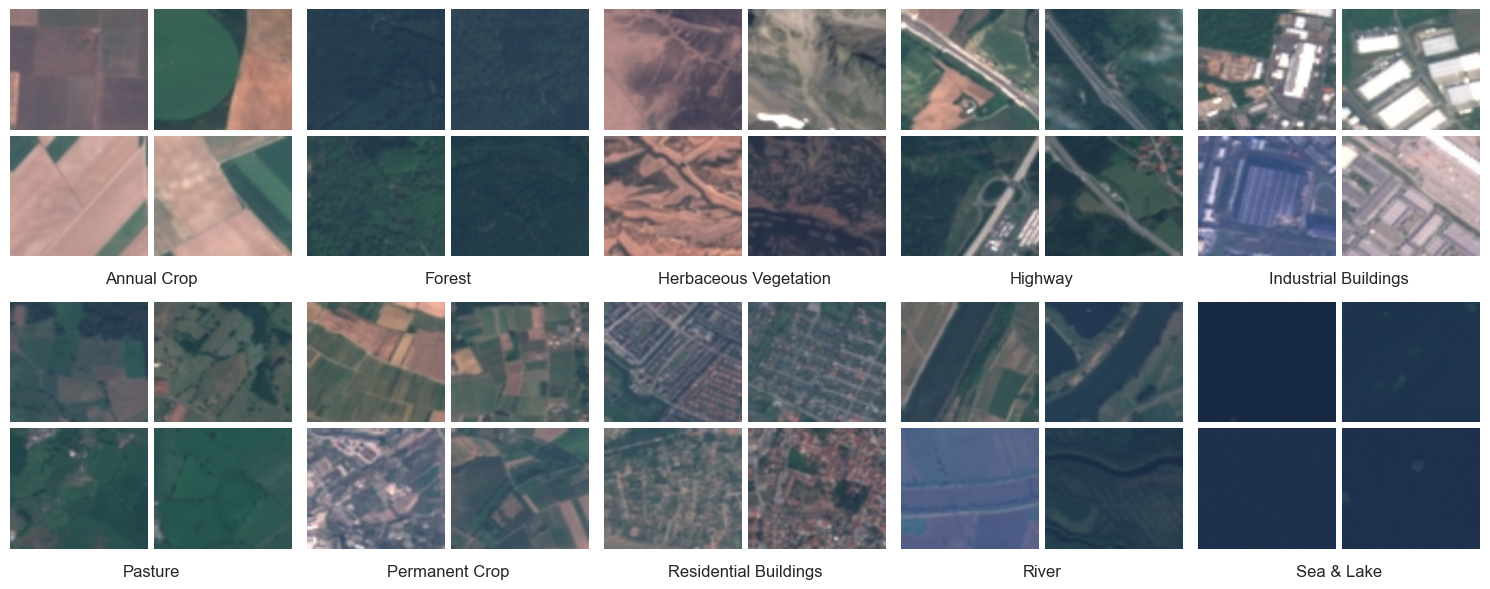

In [141]:
def plot_class_samples(dataset, num_rows=2, num_cols=5, samples_per_class=4):
    """
    Display a grid of image samples for multiple classes.
    
    Args:
        dataset: A dataset with class information in dataset.class_to_idx
        num_rows: Number of rows in the main grid (number of rows of classes)
        num_cols: Number of columns in the main grid (number of columns of classes)
        samples_per_class: Number of samples per class (must be able to form a square grid)
    """
    # Get class mapping from dataset
    class_dict = dataset.class_to_idx
    class_names = list(class_dict.keys())
    
    # Map class names to display names for better readability
    display_name_mapping = {
        'AnnualCrop': 'Annual Crop',
        'Forest': 'Forest',
        'HerbaceousVegetation': 'Herbaceous Vegetation',
        'Highway': 'Highway',
        'Industrial': 'Industrial Buildings',
        'Pasture': 'Pasture',
        'PermanentCrop': 'Permanent Crop',
        'Residential': 'Residential Buildings',
        'River': 'River',
        'SeaLake': 'Sea & Lake'
    }
    
    # Create a reverse mapping from label indices to class names
    reverse_class_dict = {v: k for k, v in class_dict.items()}
    
    # Find sample indices for each class
    samples_per_class = 4  # For a 2x2 grid per class
    class_sample_indices = {class_name: [] for class_name in class_names}
    
    for idx, (_, label) in enumerate(dataset.samples):
        class_name = reverse_class_dict[label]
        if len(class_sample_indices[class_name]) < samples_per_class:
            class_sample_indices[class_name].append(idx)
        
        # Check if we've collected enough samples for all classes
        if all(len(indices) == samples_per_class for indices in class_sample_indices.values()):
            break
    
    # Select a subset of classes if we have more than num_rows*num_cols
    if len(class_names) > num_rows * num_cols:
        selected_classes = class_names[:num_rows * num_cols]
    else:
        selected_classes = class_names
    
    # Calculate figure size to make it look good
    samples_grid_size = int(np.sqrt(samples_per_class))
    figsize = (num_cols * 3, num_rows * 3)
    
    # Create the figure
    fig = plt.figure(figsize=figsize)
    
    # Create a grid with spacing for class titles
    grid_kw = {'height_ratios': [20, 0.05] * num_rows}
    outer_grid = fig.add_gridspec(num_rows * 2, num_cols, **grid_kw)
    
    # Process each class
    for i, class_name in enumerate(selected_classes):
        row = i // num_cols
        col = i % num_cols
        
        # Create a sub-gridspec for the samples
        samples_grid = outer_grid[row * 2, col].subgridspec(samples_grid_size, samples_grid_size, wspace=0.05, hspace=0.05)
        
        # Get the image samples for this class
        indices = class_sample_indices[class_name]
        
        # Plot each sample
        for j, idx in enumerate(indices):
            sample_row = j // samples_grid_size
            sample_col = j % samples_grid_size
            
            # Get image and convert if needed
            img, _ = dataset[idx]
            
            # Convert tensor to numpy array if needed
            if isinstance(img, torch.Tensor):
                img = img.permute(1, 2, 0).numpy()
                img = stds * img + means

            # Plot the image
            ax = fig.add_subplot(samples_grid[sample_row, sample_col])
            ax.imshow(img, aspect='auto')
            ax.axis('off')
        
        # Add class title
        title_ax = fig.add_subplot(outer_grid[row * 2 + 1, col])
        display_name = display_name_mapping.get(class_name, class_name)
        title_ax.text(0.5, 0.5, display_name, ha='center', va='center', fontsize=12)
        title_ax.axis('off')
    
    plt.tight_layout()
    return fig
fig = plot_class_samples(dataset, num_rows=2, num_cols=5, samples_per_class=4)

In [31]:
# check if the dataloaders are working
for phase in data_loaders:
    print(f"Phase: {phase}")
    for images, labels in data_loaders[phase]:
        print(f"Batch size: {images.size()}, Labels: {labels.size()}")
        print(f"Labels: {labels}")
        # Check if the labels are correct
        if phase == "train":
            for label in labels:
                if label.item() < 0 or label.item() > 9:
                    print(f"Unexpected label: {label.item()}")
        else:
            for label in labels:
                if label.item() < 0 or label.item() > 9:
                    print(f"Unexpected label: {label.item()}")
        # Check if the images are correct
        if images.size(1) != 3 or images.size(2) != 256 or images.size(3) != 256:
            print(f"Unexpected image size: {images.size()}")
        else:
            print(f"Image size: {images.size()}")
        break
    break
# Check if the model is working
model = cnn()
model.to("cpu")
summary(model, (3, 256, 256), device="cpu")

Phase: train
Batch size: torch.Size([32, 3, 256, 256]), Labels: torch.Size([32])
Labels: tensor([1, 8, 7, 0, 2, 0, 4, 8, 6, 1, 8, 3, 5, 6, 4, 5, 0, 8, 9, 0, 0, 6, 5, 4,
        0, 9, 8, 1, 8, 8, 8, 6])
Image size: torch.Size([32, 3, 256, 256])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x147bb5f70>
Traceback (most recent call last):
  File "/Users/i565833/Documents/MSc/Classes/Machine Learning Topics/Work 2 - CNN/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/i565833/Documents/MSc/Classes/Machine Learning Topics/Work 2 - CNN/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Developer/CommandLineTools/Library/Fr

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-9           [-1, 32, 16, 16]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 256]       2,097,408
          Dropout-12                  [-1, 256]               0
           Linear-13                   [-1, 10]           2,570
Total params: 2,105,162
Trainable param

Using device: cuda
Number of classes: 10
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:27<00:00, 21.59batch/s, loss=1.21]


Epoch 1 - Train Loss: 1.2148 - Train Accuracy: 0.5746 - Train F1: 0.5680 - Train Precision: 0.5652 - Train Recall: 0.5746


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.51batch/s, loss=0.88] 


Epoch 1 - Val Loss: 0.8590 - Val Accuracy: 0.6985 - Val F1: 0.6813 - Val Precision: 0.7087 - Val Recall: 0.6985
Validation loss improved from inf to 0.8590.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:27<00:00, 21.77batch/s, loss=0.953]


Epoch 2 - Train Loss: 0.9527 - Train Accuracy: 0.6706 - Train F1: 0.6668 - Train Precision: 0.6659 - Train Recall: 0.6706


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 24.03batch/s, loss=0.768]


Epoch 1 - Val Loss: 0.7501 - Val Accuracy: 0.7410 - Val F1: 0.7355 - Val Precision: 0.7517 - Val Recall: 0.7410
Validation loss improved from 0.8590 to 0.7501.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:27<00:00, 21.73batch/s, loss=0.851]


Epoch 3 - Train Loss: 0.8505 - Train Accuracy: 0.7007 - Train F1: 0.6985 - Train Precision: 0.6979 - Train Recall: 0.7007


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.85batch/s, loss=0.732]


Epoch 1 - Val Loss: 0.7132 - Val Accuracy: 0.7528 - Val F1: 0.7529 - Val Precision: 0.7693 - Val Recall: 0.7528
Validation loss improved from 0.7501 to 0.7132.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:27<00:00, 21.76batch/s, loss=0.777]


Epoch 4 - Train Loss: 0.7770 - Train Accuracy: 0.7308 - Train F1: 0.7289 - Train Precision: 0.7288 - Train Recall: 0.7308


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.44batch/s, loss=0.681]


Epoch 1 - Val Loss: 0.6575 - Val Accuracy: 0.7726 - Val F1: 0.7693 - Val Precision: 0.7826 - Val Recall: 0.7726
Validation loss improved from 0.7132 to 0.6575.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:27<00:00, 21.80batch/s, loss=0.709]


Epoch 5 - Train Loss: 0.7089 - Train Accuracy: 0.7539 - Train F1: 0.7523 - Train Precision: 0.7517 - Train Recall: 0.7539


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 24.23batch/s, loss=0.68] 


Epoch 1 - Val Loss: 0.6501 - Val Accuracy: 0.7721 - Val F1: 0.7696 - Val Precision: 0.7806 - Val Recall: 0.7721
Validation loss improved from 0.6575 to 0.6501.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 6/40: 100%|██████████| 591/591 [00:27<00:00, 21.75batch/s, loss=0.674]


Epoch 6 - Train Loss: 0.6736 - Train Accuracy: 0.7678 - Train F1: 0.7662 - Train Precision: 0.7657 - Train Recall: 0.7678


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.70batch/s, loss=0.671]


Epoch 1 - Val Loss: 0.6443 - Val Accuracy: 0.7736 - Val F1: 0.7702 - Val Precision: 0.7823 - Val Recall: 0.7736
Validation loss did not improve from 0.6501 to 0.6443.
Early stop counter: 1/3


Train Epoch 7/40: 100%|██████████| 591/591 [00:27<00:00, 21.77batch/s, loss=0.638]


Epoch 7 - Train Loss: 0.6377 - Train Accuracy: 0.7799 - Train F1: 0.7785 - Train Precision: 0.7780 - Train Recall: 0.7799


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.91batch/s, loss=0.6]  


Epoch 1 - Val Loss: 0.5920 - Val Accuracy: 0.7931 - Val F1: 0.7907 - Val Precision: 0.8028 - Val Recall: 0.7931
Validation loss improved from 0.6501 to 0.5920.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 8/40: 100%|██████████| 591/591 [00:27<00:00, 21.83batch/s, loss=0.602]


Epoch 8 - Train Loss: 0.6018 - Train Accuracy: 0.7926 - Train F1: 0.7914 - Train Precision: 0.7910 - Train Recall: 0.7926


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.73batch/s, loss=0.626]


Epoch 1 - Val Loss: 0.5991 - Val Accuracy: 0.7896 - Val F1: 0.7848 - Val Precision: 0.7900 - Val Recall: 0.7896
Validation loss did not improve from 0.5920 to 0.5991.
Early stop counter: 1/3


Train Epoch 9/40: 100%|██████████| 591/591 [00:27<00:00, 21.77batch/s, loss=0.578]


Epoch 9 - Train Loss: 0.5782 - Train Accuracy: 0.8012 - Train F1: 0.8001 - Train Precision: 0.7998 - Train Recall: 0.8012


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.76batch/s, loss=0.575]


Epoch 1 - Val Loss: 0.5575 - Val Accuracy: 0.8044 - Val F1: 0.8055 - Val Precision: 0.8148 - Val Recall: 0.8044
Validation loss improved from 0.5920 to 0.5575.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 10/40: 100%|██████████| 591/591 [00:27<00:00, 21.64batch/s, loss=0.549]


Epoch 10 - Train Loss: 0.5489 - Train Accuracy: 0.8075 - Train F1: 0.8064 - Train Precision: 0.8060 - Train Recall: 0.8075


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.84batch/s, loss=0.536]


Epoch 1 - Val Loss: 0.5177 - Val Accuracy: 0.8247 - Val F1: 0.8239 - Val Precision: 0.8274 - Val Recall: 0.8247
Validation loss improved from 0.5575 to 0.5177.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 11/40: 100%|██████████| 591/591 [00:27<00:00, 21.79batch/s, loss=0.524]


Epoch 11 - Train Loss: 0.5242 - Train Accuracy: 0.8174 - Train F1: 0.8163 - Train Precision: 0.8160 - Train Recall: 0.8174


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.79batch/s, loss=0.575]


Epoch 1 - Val Loss: 0.5566 - Val Accuracy: 0.8114 - Val F1: 0.8090 - Val Precision: 0.8127 - Val Recall: 0.8114
Validation loss did not improve from 0.5177 to 0.5566.
Early stop counter: 1/3


Train Epoch 12/40: 100%|██████████| 591/591 [00:27<00:00, 21.72batch/s, loss=0.501]


Epoch 12 - Train Loss: 0.5012 - Train Accuracy: 0.8259 - Train F1: 0.8251 - Train Precision: 0.8249 - Train Recall: 0.8259


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.75batch/s, loss=0.525]


Epoch 1 - Val Loss: 0.5064 - Val Accuracy: 0.8230 - Val F1: 0.8207 - Val Precision: 0.8233 - Val Recall: 0.8230
Validation loss improved from 0.5177 to 0.5064.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-4.pth


Train Epoch 13/40: 100%|██████████| 591/591 [00:27<00:00, 21.80batch/s, loss=0.479]


Epoch 13 - Train Loss: 0.4785 - Train Accuracy: 0.8350 - Train F1: 0.8341 - Train Precision: 0.8339 - Train Recall: 0.8350


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.82batch/s, loss=0.537]


Epoch 1 - Val Loss: 0.5180 - Val Accuracy: 0.8178 - Val F1: 0.8168 - Val Precision: 0.8247 - Val Recall: 0.8178
Validation loss did not improve from 0.5064 to 0.5180.
Early stop counter: 1/3


Train Epoch 14/40: 100%|██████████| 591/591 [00:27<00:00, 21.65batch/s, loss=0.455]


Epoch 14 - Train Loss: 0.4551 - Train Accuracy: 0.8429 - Train F1: 0.8421 - Train Precision: 0.8418 - Train Recall: 0.8429


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 24.00batch/s, loss=0.546]


Epoch 1 - Val Loss: 0.5360 - Val Accuracy: 0.8081 - Val F1: 0.8063 - Val Precision: 0.8134 - Val Recall: 0.8081
Validation loss did not improve from 0.5064 to 0.5360.
Early stop counter: 2/3


Train Epoch 15/40: 100%|██████████| 591/591 [00:27<00:00, 21.71batch/s, loss=0.449]


Epoch 15 - Train Loss: 0.4488 - Train Accuracy: 0.8461 - Train F1: 0.8453 - Train Precision: 0.8451 - Train Recall: 0.8461


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.18batch/s, loss=0.549]


Epoch 1 - Val Loss: 0.5259 - Val Accuracy: 0.8217 - Val F1: 0.8204 - Val Precision: 0.8353 - Val Recall: 0.8217
Validation loss did not improve from 0.5064 to 0.5259.
Early stop counter: 3/3
Early stopping triggered at epoch 15.


Test Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 21.19batch/s, loss=0.572]


Test loss: 0.5499086570816012 accuracy: 0.8187654320987654 precision: 0.8324074358089204 recall: 0.8187654320987654 f1: 0.8179720601941487


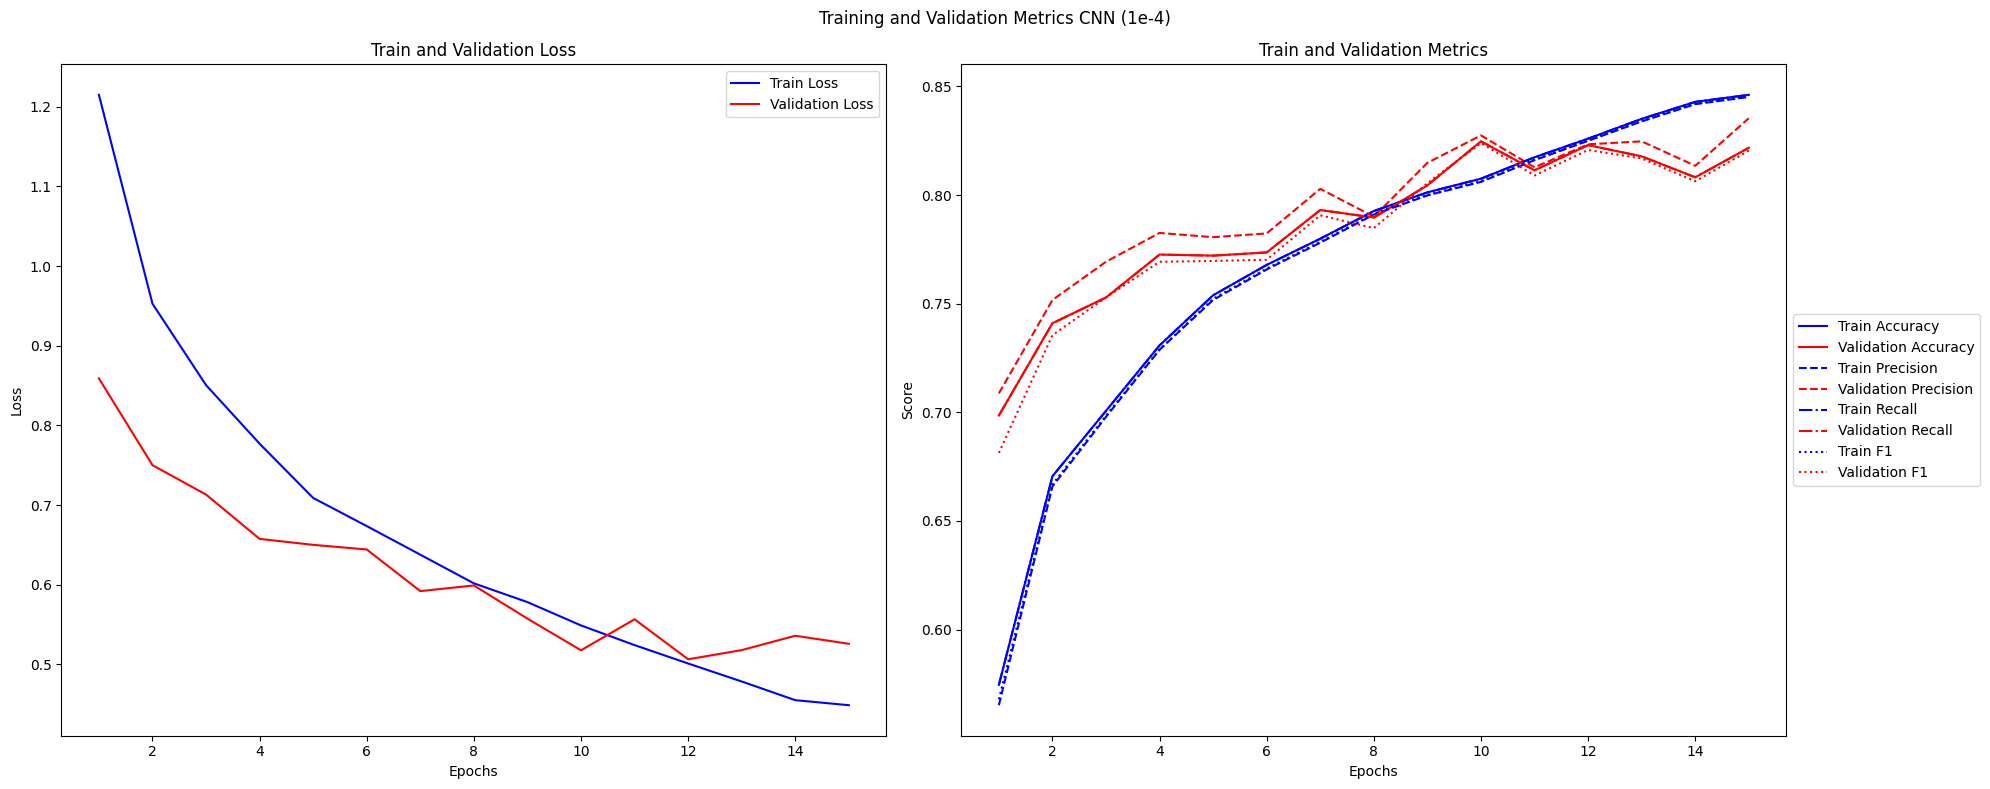

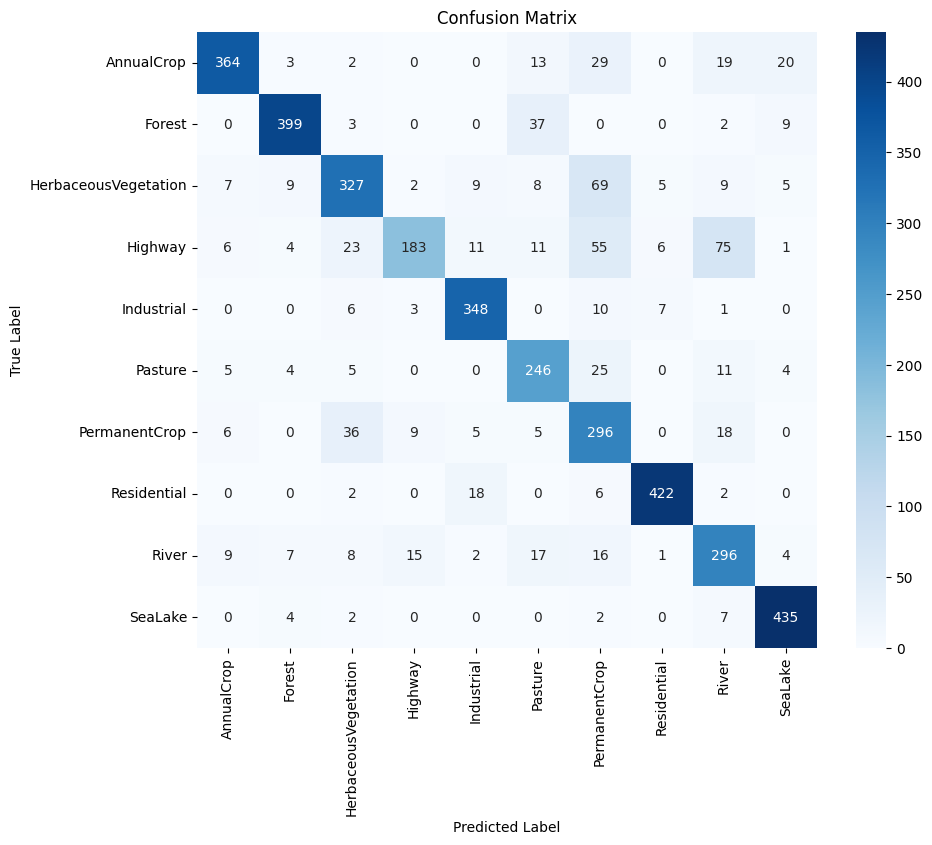

In [ ]:
epochs = 40
model = cnn()

cnn_trainer_1e4 = Trainer(
    model=model,
    dataloader=data_loaders,
    epochs=epochs,
    learning_rate=1e-4,
    best_model_filename='./best_model_dense_cnn_1e-4.pth',
    best_model_path=f"./models",
)

cnn_trainer_1e4.fit()
history = cnn_trainer_1e4.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

cnn_trainer_1e4.plot_metrics(title="Training and Validation Metrics CNN (1e-4)")
cnn_trainer_1e4.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_cnn_1e4_df = pd.DataFrame(cnn_trainer_1e4.history)
metrics_cnn_1e4_df.to_csv('./metrics/metrics_cnn_1e-4.csv', index=False)

Using device: cuda
Number of classes: 10
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:27<00:00, 21.46batch/s, loss=1.67]


Epoch 1 - Train Loss: 1.6719 - Train Accuracy: 0.5292 - Train F1: 0.5249 - Train Precision: 0.5219 - Train Recall: 0.5292


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.88batch/s, loss=1.1] 


Epoch 1 - Val Loss: 1.1324 - Val Accuracy: 0.6183 - Val F1: 0.6191 - Val Precision: 0.6912 - Val Recall: 0.6183
Validation loss improved from inf to 1.1324.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-3.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:28<00:00, 20.72batch/s, loss=1.01]


Epoch 2 - Train Loss: 1.0136 - Train Accuracy: 0.6444 - Train F1: 0.6405 - Train Precision: 0.6386 - Train Recall: 0.6444


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 22.01batch/s, loss=0.979]


Epoch 1 - Val Loss: 0.9448 - Val Accuracy: 0.6558 - Val F1: 0.6371 - Val Precision: 0.6710 - Val Recall: 0.6558
Validation loss improved from 1.1324 to 0.9448.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-3.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:28<00:00, 20.65batch/s, loss=0.905]


Epoch 3 - Train Loss: 0.9049 - Train Accuracy: 0.6828 - Train F1: 0.6798 - Train Precision: 0.6787 - Train Recall: 0.6828


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.47batch/s, loss=0.958]


Epoch 1 - Val Loss: 0.9192 - Val Accuracy: 0.6891 - Val F1: 0.6669 - Val Precision: 0.7027 - Val Recall: 0.6891
Validation loss improved from 0.9448 to 0.9192.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-3.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:28<00:00, 20.50batch/s, loss=0.794]


Epoch 4 - Train Loss: 0.7937 - Train Accuracy: 0.7248 - Train F1: 0.7228 - Train Precision: 0.7222 - Train Recall: 0.7248


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 20.26batch/s, loss=0.778]


Epoch 1 - Val Loss: 0.7704 - Val Accuracy: 0.7474 - Val F1: 0.7459 - Val Precision: 0.7579 - Val Recall: 0.7474
Validation loss improved from 0.9192 to 0.7704.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-3.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:28<00:00, 20.66batch/s, loss=0.709]


Epoch 5 - Train Loss: 0.7088 - Train Accuracy: 0.7576 - Train F1: 0.7557 - Train Precision: 0.7549 - Train Recall: 0.7576


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 23.35batch/s, loss=0.661]


Epoch 1 - Val Loss: 0.6426 - Val Accuracy: 0.7711 - Val F1: 0.7633 - Val Precision: 0.7891 - Val Recall: 0.7711
Validation loss improved from 0.7704 to 0.6426.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-3.pth


Train Epoch 6/40: 100%|██████████| 591/591 [00:28<00:00, 20.46batch/s, loss=0.673]


Epoch 6 - Train Loss: 0.6728 - Train Accuracy: 0.7652 - Train F1: 0.7635 - Train Precision: 0.7626 - Train Recall: 0.7652


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 20.14batch/s, loss=0.595]


Epoch 1 - Val Loss: 0.5779 - Val Accuracy: 0.8096 - Val F1: 0.8053 - Val Precision: 0.8077 - Val Recall: 0.8096
Validation loss improved from 0.6426 to 0.5779.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-3.pth


Train Epoch 7/40: 100%|██████████| 591/591 [00:28<00:00, 20.50batch/s, loss=0.615]


Epoch 7 - Train Loss: 0.6151 - Train Accuracy: 0.7860 - Train F1: 0.7845 - Train Precision: 0.7837 - Train Recall: 0.7860


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 20.20batch/s, loss=0.79] 


Epoch 1 - Val Loss: 0.7548 - Val Accuracy: 0.7390 - Val F1: 0.7333 - Val Precision: 0.7681 - Val Recall: 0.7390
Validation loss did not improve from 0.5779 to 0.7548.
Early stop counter: 1/3


Train Epoch 8/40: 100%|██████████| 591/591 [00:28<00:00, 21.10batch/s, loss=0.584]


Epoch 8 - Train Loss: 0.5837 - Train Accuracy: 0.8014 - Train F1: 0.8001 - Train Precision: 0.7995 - Train Recall: 0.8014


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 19.21batch/s, loss=0.548]


Epoch 1 - Val Loss: 0.5474 - Val Accuracy: 0.8153 - Val F1: 0.8136 - Val Precision: 0.8199 - Val Recall: 0.8153
Validation loss improved from 0.5779 to 0.5474.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_dense_cnn_1e-3.pth


Train Epoch 9/40: 100%|██████████| 591/591 [00:28<00:00, 20.99batch/s, loss=0.537]


Epoch 9 - Train Loss: 0.5370 - Train Accuracy: 0.8167 - Train F1: 0.8158 - Train Precision: 0.8153 - Train Recall: 0.8167


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 19.71batch/s, loss=0.582]


Epoch 1 - Val Loss: 0.5604 - Val Accuracy: 0.8109 - Val F1: 0.8147 - Val Precision: 0.8254 - Val Recall: 0.8109
Validation loss did not improve from 0.5474 to 0.5604.
Early stop counter: 1/3


Train Epoch 10/40: 100%|██████████| 591/591 [00:28<00:00, 20.93batch/s, loss=0.522]


Epoch 10 - Train Loss: 0.5221 - Train Accuracy: 0.8238 - Train F1: 0.8230 - Train Precision: 0.8226 - Train Recall: 0.8238


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 20.20batch/s, loss=0.572]


Epoch 1 - Val Loss: 0.5505 - Val Accuracy: 0.8190 - Val F1: 0.8157 - Val Precision: 0.8166 - Val Recall: 0.8190
Validation loss did not improve from 0.5474 to 0.5505.
Early stop counter: 2/3


Train Epoch 11/40: 100%|██████████| 591/591 [00:28<00:00, 20.67batch/s, loss=0.471]


Epoch 11 - Train Loss: 0.4713 - Train Accuracy: 0.8378 - Train F1: 0.8368 - Train Precision: 0.8363 - Train Recall: 0.8378


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 19.20batch/s, loss=0.606]


Epoch 1 - Val Loss: 0.5822 - Val Accuracy: 0.8131 - Val F1: 0.8078 - Val Precision: 0.8179 - Val Recall: 0.8131
Validation loss did not improve from 0.5474 to 0.5822.
Early stop counter: 3/3
Early stopping triggered at epoch 11.


Test Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 19.02batch/s, loss=0.634]


Test loss: 0.6076434270119456 accuracy: 0.8017283950617284 precision: 0.8055767472919639 recall: 0.8017283950617284 f1: 0.7951459997930248


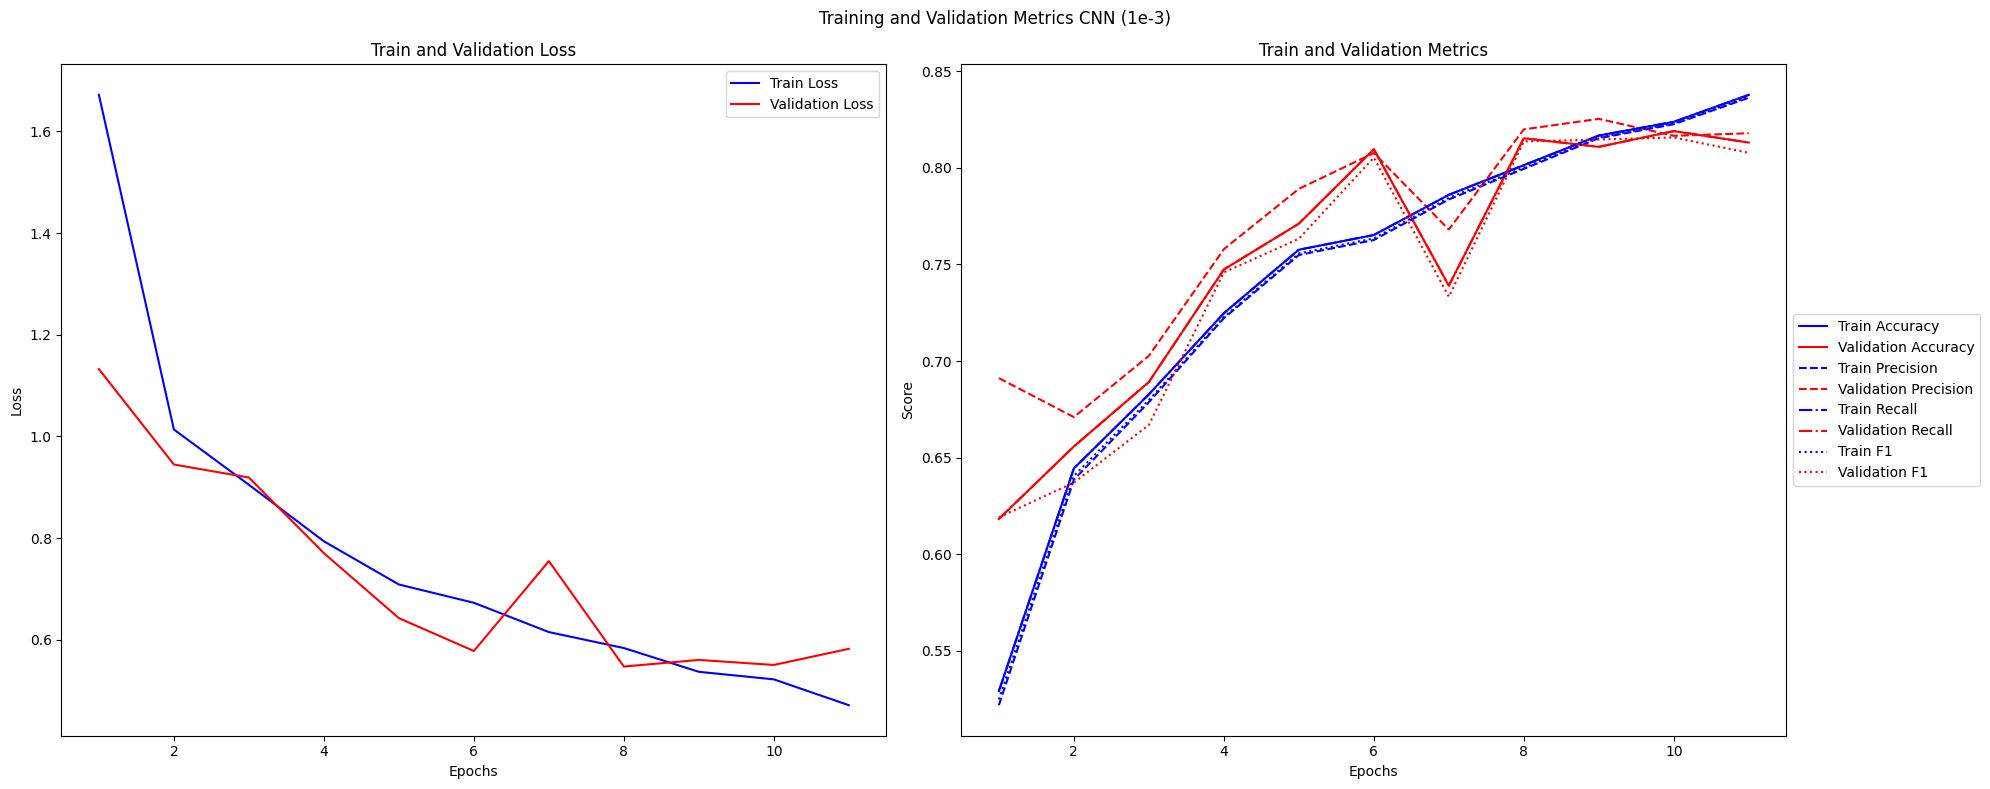

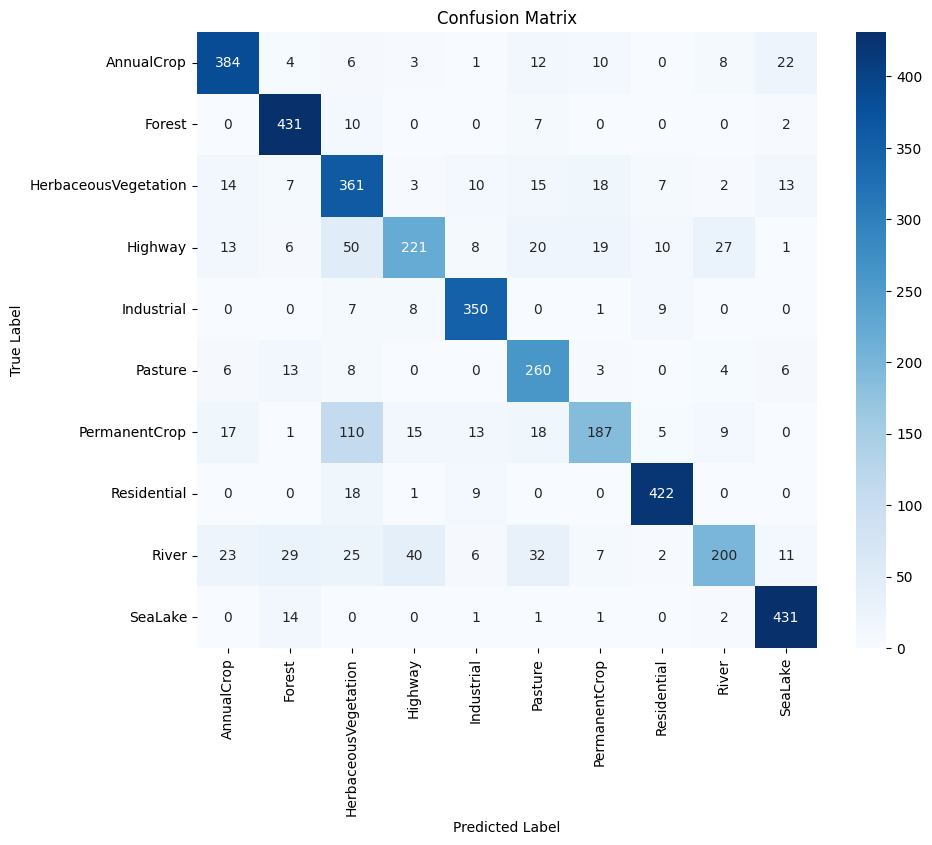

In [ ]:
epochs = 40
model = cnn()

cnn_trainer_1e3 = Trainer(
    model=model,
    dataloader=data_loaders,
    epochs=epochs,
    learning_rate=1e-3,
    best_model_filename='./best_model_dense_cnn_1e-3.pth',
    best_model_path=f"./models",
)

cnn_trainer_1e3.fit()
history = cnn_trainer_1e3.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

cnn_trainer_1e3.plot_metrics(title="Training and Validation Metrics CNN (1e-3)")
cnn_trainer_1e3.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_cnn_1e3_df = pd.DataFrame(cnn_trainer_1e3.history)
metrics_cnn_1e3_df.to_csv('./metrics/metrics_cnn_1e-3.csv', index=False)

# Fine-Tuning Image Classifier - ResNet18 Full Parameters

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Using device: cuda
Number of classes: 9
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:49<00:00, 12.04batch/s, loss=0.221]


Epoch 1 - Train Loss: 0.2208 - Train Accuracy: 0.9266 - Train F1: 0.9266 - Train Precision: 0.9270 - Train Recall: 0.9266


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 21.16batch/s, loss=0.0888]


Epoch 1 - Val Loss: 0.0851 - Val Accuracy: 0.9706 - Val F1: 0.9706 - Val Precision: 0.9713 - Val Recall: 0.9706
Validation loss improved from inf to 0.0851.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_full.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:49<00:00, 11.94batch/s, loss=0.0866]


Epoch 2 - Train Loss: 0.0866 - Train Accuracy: 0.9734 - Train F1: 0.9734 - Train Precision: 0.9734 - Train Recall: 0.9734


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 22.52batch/s, loss=0.0904]


Epoch 1 - Val Loss: 0.0880 - Val Accuracy: 0.9714 - Val F1: 0.9713 - Val Precision: 0.9716 - Val Recall: 0.9714
Validation loss did not improve from 0.0851 to 0.0880.
Early stop counter: 1/3


Train Epoch 3/40: 100%|██████████| 591/591 [00:49<00:00, 12.00batch/s, loss=0.0525]


Epoch 3 - Train Loss: 0.0525 - Train Accuracy: 0.9831 - Train F1: 0.9831 - Train Precision: 0.9831 - Train Recall: 0.9831


Val Epoch 1/40: 100%|██████████| 127/127 [00:05<00:00, 22.59batch/s, loss=0.0991]


Epoch 1 - Val Loss: 0.0957 - Val Accuracy: 0.9711 - Val F1: 0.9712 - Val Precision: 0.9722 - Val Recall: 0.9711
Validation loss did not improve from 0.0851 to 0.0957.
Early stop counter: 2/3


Train Epoch 4/40: 100%|██████████| 591/591 [00:49<00:00, 11.92batch/s, loss=0.0386]


Epoch 4 - Train Loss: 0.0386 - Train Accuracy: 0.9877 - Train F1: 0.9877 - Train Precision: 0.9877 - Train Recall: 0.9877


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 20.59batch/s, loss=0.0907]


Epoch 1 - Val Loss: 0.0866 - Val Accuracy: 0.9731 - Val F1: 0.9730 - Val Precision: 0.9734 - Val Recall: 0.9731
Validation loss did not improve from 0.0851 to 0.0866.
Early stop counter: 3/3
Early stopping triggered at epoch 4.


Test Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 20.73batch/s, loss=0.106] 


Test loss: 0.10152899838918013 accuracy: 0.9696296296296296 precision: 0.9705315824113294 recall: 0.9696296296296296 f1: 0.9693887786468179


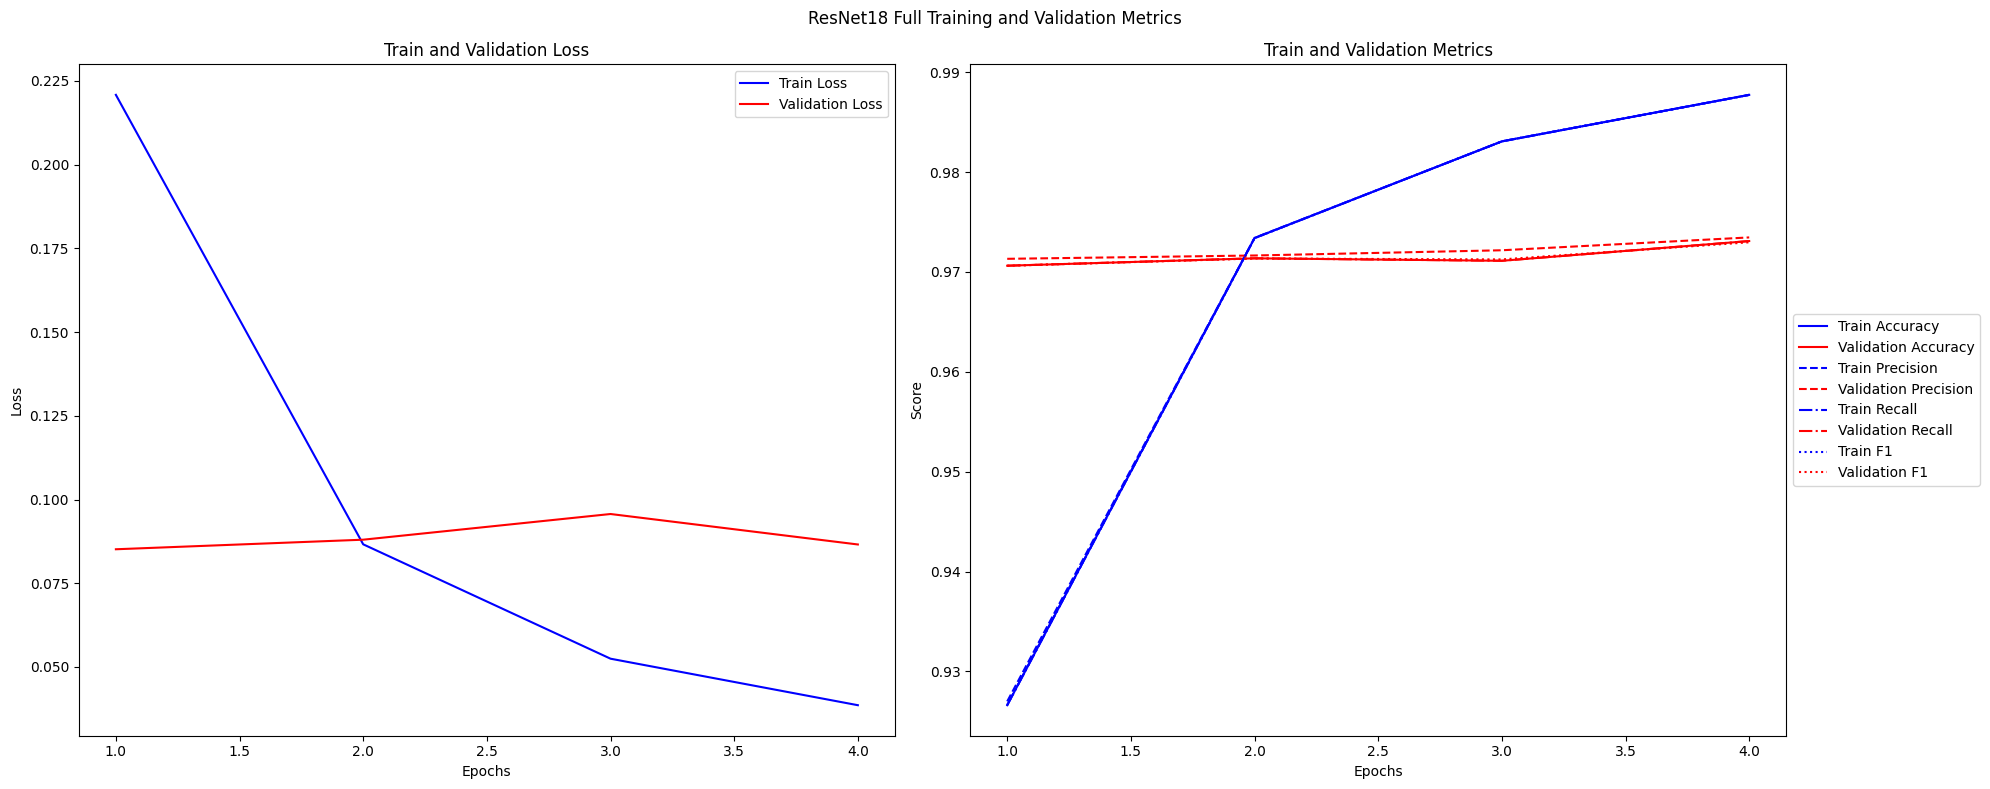

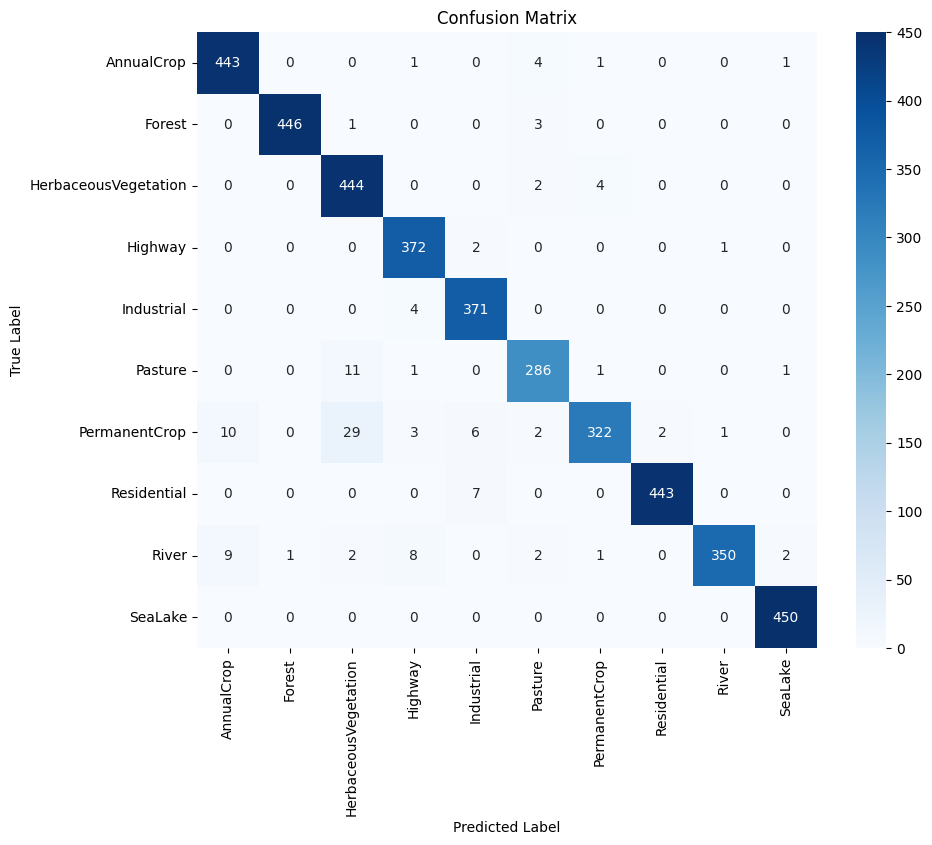

In [ ]:
# Load the pretrained model
# Use torchvision's ResNet18 model
resnet18_full = torchvision.models.resnet18(pretrained=True)
resnet18_full.fc = nn.Linear(resnet18_full.fc.in_features, 10)

epochs = 40

resnet18_full_trainer = Trainer(
    model=resnet18_full,
    dataloader=data_loaders,
    epochs=epochs,
    learning_rate=1e-4,
    best_model_filename='./best_model_resnet18_full.pth',
    best_model_path=f"./models",
)

resnet18_full_trainer.fit()
history = resnet18_full_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

# Plot training and validation metrics
resnet18_full_trainer.plot_metrics(title="ResNet18 Full Training and Validation Metrics")
resnet18_full_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_resnet18_full_df = pd.DataFrame(resnet18_full_trainer.history)
metrics_resnet18_full_df.to_csv('./metrics/metrics_resnet18_full.csv', index=False)

# Fine-Tuning Image Classifier - ResNet18 Frozen Parameters

Using device: mps
Number of classes: 9
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:47<00:00, 12.39batch/s, loss=1.45]


Epoch 1 - Train Loss: 1.4486 - Train Accuracy: 0.6278 - Train F1: 0.6220 - Train Precision: 0.6299 - Train Recall: 0.6278


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.19batch/s, loss=0.889]


Epoch 1 - Val Loss: 0.8740 - Val Accuracy: 0.8151 - Val F1: 0.8082 - Val Precision: 0.8084 - Val Recall: 0.8151
Validation loss improved from inf to 0.8740.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:47<00:00, 12.39batch/s, loss=0.771]


Epoch 2 - Train Loss: 0.7705 - Train Accuracy: 0.8194 - Train F1: 0.8164 - Train Precision: 0.8158 - Train Recall: 0.8194


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.626]


Epoch 1 - Val Loss: 0.6084 - Val Accuracy: 0.8506 - Val F1: 0.8475 - Val Precision: 0.8477 - Val Recall: 0.8506
Validation loss improved from 0.8740 to 0.6084.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:47<00:00, 12.39batch/s, loss=0.592]


Epoch 3 - Train Loss: 0.5917 - Train Accuracy: 0.8474 - Train F1: 0.8454 - Train Precision: 0.8447 - Train Recall: 0.8474


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.14batch/s, loss=0.494]


Epoch 1 - Val Loss: 0.4819 - Val Accuracy: 0.8709 - Val F1: 0.8693 - Val Precision: 0.8687 - Val Recall: 0.8709
Validation loss improved from 0.6084 to 0.4819.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:47<00:00, 12.38batch/s, loss=0.505]


Epoch 4 - Train Loss: 0.5048 - Train Accuracy: 0.8628 - Train F1: 0.8615 - Train Precision: 0.8611 - Train Recall: 0.8628


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.14batch/s, loss=0.433]


Epoch 1 - Val Loss: 0.4204 - Val Accuracy: 0.8847 - Val F1: 0.8833 - Val Precision: 0.8834 - Val Recall: 0.8847
Validation loss improved from 0.4819 to 0.4204.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:47<00:00, 12.38batch/s, loss=0.456]


Epoch 5 - Train Loss: 0.4562 - Train Accuracy: 0.8703 - Train F1: 0.8693 - Train Precision: 0.8689 - Train Recall: 0.8703


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.14batch/s, loss=0.388]


Epoch 1 - Val Loss: 0.3769 - Val Accuracy: 0.8973 - Val F1: 0.8957 - Val Precision: 0.8961 - Val Recall: 0.8973
Validation loss improved from 0.4204 to 0.3769.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 6/40: 100%|██████████| 591/591 [00:47<00:00, 12.38batch/s, loss=0.421]


Epoch 6 - Train Loss: 0.4207 - Train Accuracy: 0.8771 - Train F1: 0.8762 - Train Precision: 0.8759 - Train Recall: 0.8771


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.36] 


Epoch 1 - Val Loss: 0.3488 - Val Accuracy: 0.8985 - Val F1: 0.8979 - Val Precision: 0.8983 - Val Recall: 0.8985
Validation loss improved from 0.3769 to 0.3488.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 7/40: 100%|██████████| 591/591 [00:47<00:00, 12.39batch/s, loss=0.391]


Epoch 7 - Train Loss: 0.3906 - Train Accuracy: 0.8830 - Train F1: 0.8823 - Train Precision: 0.8819 - Train Recall: 0.8830


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.14batch/s, loss=0.334]


Epoch 1 - Val Loss: 0.3236 - Val Accuracy: 0.9072 - Val F1: 0.9059 - Val Precision: 0.9065 - Val Recall: 0.9072
Validation loss improved from 0.3488 to 0.3236.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 8/40: 100%|██████████| 591/591 [00:47<00:00, 12.35batch/s, loss=0.372]


Epoch 8 - Train Loss: 0.3723 - Train Accuracy: 0.8875 - Train F1: 0.8868 - Train Precision: 0.8866 - Train Recall: 0.8875


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.19batch/s, loss=0.322]


Epoch 1 - Val Loss: 0.3131 - Val Accuracy: 0.9049 - Val F1: 0.9039 - Val Precision: 0.9041 - Val Recall: 0.9049
Validation loss improved from 0.3236 to 0.3131.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 9/40: 100%|██████████| 591/591 [00:47<00:00, 12.38batch/s, loss=0.359]


Epoch 9 - Train Loss: 0.3590 - Train Accuracy: 0.8900 - Train F1: 0.8894 - Train Precision: 0.8892 - Train Recall: 0.8900


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.13batch/s, loss=0.3]  


Epoch 1 - Val Loss: 0.2906 - Val Accuracy: 0.9128 - Val F1: 0.9121 - Val Precision: 0.9121 - Val Recall: 0.9128
Validation loss improved from 0.3131 to 0.2906.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 10/40: 100%|██████████| 591/591 [00:47<00:00, 12.40batch/s, loss=0.342]


Epoch 10 - Train Loss: 0.3416 - Train Accuracy: 0.8905 - Train F1: 0.8899 - Train Precision: 0.8897 - Train Recall: 0.8905


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.14batch/s, loss=0.288]


Epoch 1 - Val Loss: 0.2794 - Val Accuracy: 0.9156 - Val F1: 0.9152 - Val Precision: 0.9154 - Val Recall: 0.9156
Validation loss improved from 0.2906 to 0.2794.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 11/40: 100%|██████████| 591/591 [00:47<00:00, 12.36batch/s, loss=0.329]


Epoch 11 - Train Loss: 0.3289 - Train Accuracy: 0.8979 - Train F1: 0.8974 - Train Precision: 0.8972 - Train Recall: 0.8979


Val Epoch 1/40: 100%|██████████| 127/127 [00:36<00:00,  3.47batch/s, loss=0.277]


Epoch 1 - Val Loss: 0.2689 - Val Accuracy: 0.9190 - Val F1: 0.9183 - Val Precision: 0.9191 - Val Recall: 0.9190
Validation loss improved from 0.2794 to 0.2689.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 12/40: 100%|██████████| 591/591 [00:47<00:00, 12.38batch/s, loss=0.319]


Epoch 12 - Train Loss: 0.3189 - Train Accuracy: 0.8991 - Train F1: 0.8986 - Train Precision: 0.8983 - Train Recall: 0.8991


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.01batch/s, loss=0.27] 


Epoch 1 - Val Loss: 0.2613 - Val Accuracy: 0.9222 - Val F1: 0.9220 - Val Precision: 0.9220 - Val Recall: 0.9222
Validation loss improved from 0.2689 to 0.2613.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 13/40: 100%|██████████| 591/591 [00:48<00:00, 12.25batch/s, loss=0.31] 


Epoch 13 - Train Loss: 0.3104 - Train Accuracy: 0.9017 - Train F1: 0.9012 - Train Precision: 0.9010 - Train Recall: 0.9017


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.14batch/s, loss=0.266]


Epoch 1 - Val Loss: 0.2587 - Val Accuracy: 0.9185 - Val F1: 0.9175 - Val Precision: 0.9194 - Val Recall: 0.9185
Validation loss did not improve from 0.2613 to 0.2587.
Early stop counter: 1/3


Train Epoch 14/40: 100%|██████████| 591/591 [00:48<00:00, 12.29batch/s, loss=0.305]


Epoch 14 - Train Loss: 0.3048 - Train Accuracy: 0.9023 - Train F1: 0.9019 - Train Precision: 0.9018 - Train Recall: 0.9023


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.10batch/s, loss=0.261]


Epoch 1 - Val Loss: 0.2527 - Val Accuracy: 0.9222 - Val F1: 0.9215 - Val Precision: 0.9232 - Val Recall: 0.9222
Validation loss improved from 0.2613 to 0.2527.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 15/40: 100%|██████████| 591/591 [00:48<00:00, 12.21batch/s, loss=0.3]  


Epoch 15 - Train Loss: 0.2998 - Train Accuracy: 0.9046 - Train F1: 0.9041 - Train Precision: 0.9039 - Train Recall: 0.9046


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.252]


Epoch 1 - Val Loss: 0.2437 - Val Accuracy: 0.9240 - Val F1: 0.9234 - Val Precision: 0.9237 - Val Recall: 0.9240
Validation loss improved from 0.2527 to 0.2437.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 16/40: 100%|██████████| 591/591 [00:48<00:00, 12.18batch/s, loss=0.29] 


Epoch 16 - Train Loss: 0.2901 - Train Accuracy: 0.9068 - Train F1: 0.9064 - Train Precision: 0.9062 - Train Recall: 0.9068


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.249]


Epoch 1 - Val Loss: 0.2410 - Val Accuracy: 0.9222 - Val F1: 0.9214 - Val Precision: 0.9226 - Val Recall: 0.9222
Validation loss improved from 0.2437 to 0.2410.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 17/40: 100%|██████████| 591/591 [00:48<00:00, 12.20batch/s, loss=0.283]


Epoch 17 - Train Loss: 0.2831 - Train Accuracy: 0.9092 - Train F1: 0.9088 - Train Precision: 0.9087 - Train Recall: 0.9092


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.243]


Epoch 1 - Val Loss: 0.2367 - Val Accuracy: 0.9262 - Val F1: 0.9260 - Val Precision: 0.9262 - Val Recall: 0.9262
Validation loss improved from 0.2410 to 0.2367.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 18/40: 100%|██████████| 591/591 [00:48<00:00, 12.25batch/s, loss=0.282]


Epoch 18 - Train Loss: 0.2821 - Train Accuracy: 0.9073 - Train F1: 0.9070 - Train Precision: 0.9068 - Train Recall: 0.9073


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.09batch/s, loss=0.243]


Epoch 1 - Val Loss: 0.2349 - Val Accuracy: 0.9249 - Val F1: 0.9244 - Val Precision: 0.9249 - Val Recall: 0.9249
Validation loss did not improve from 0.2367 to 0.2349.
Early stop counter: 1/3


Train Epoch 19/40: 100%|██████████| 591/591 [00:47<00:00, 12.35batch/s, loss=0.278]


Epoch 19 - Train Loss: 0.2784 - Train Accuracy: 0.9098 - Train F1: 0.9095 - Train Precision: 0.9093 - Train Recall: 0.9098


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.02batch/s, loss=0.233]


Epoch 1 - Val Loss: 0.2256 - Val Accuracy: 0.9272 - Val F1: 0.9269 - Val Precision: 0.9270 - Val Recall: 0.9272
Validation loss improved from 0.2367 to 0.2256.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 20/40: 100%|██████████| 591/591 [00:48<00:00, 12.27batch/s, loss=0.269]


Epoch 20 - Train Loss: 0.2694 - Train Accuracy: 0.9117 - Train F1: 0.9113 - Train Precision: 0.9111 - Train Recall: 0.9117


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.231]


Epoch 1 - Val Loss: 0.2232 - Val Accuracy: 0.9264 - Val F1: 0.9263 - Val Precision: 0.9266 - Val Recall: 0.9264
Validation loss improved from 0.2256 to 0.2232.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 21/40: 100%|██████████| 591/591 [00:48<00:00, 12.26batch/s, loss=0.274]


Epoch 21 - Train Loss: 0.2737 - Train Accuracy: 0.9119 - Train F1: 0.9116 - Train Precision: 0.9115 - Train Recall: 0.9119


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.08batch/s, loss=0.231]


Epoch 1 - Val Loss: 0.2237 - Val Accuracy: 0.9277 - Val F1: 0.9270 - Val Precision: 0.9270 - Val Recall: 0.9277
Validation loss did not improve from 0.2232 to 0.2237.
Early stop counter: 1/3


Train Epoch 22/40: 100%|██████████| 591/591 [00:48<00:00, 12.17batch/s, loss=0.27] 


Epoch 22 - Train Loss: 0.2697 - Train Accuracy: 0.9115 - Train F1: 0.9112 - Train Precision: 0.9111 - Train Recall: 0.9115


Val Epoch 1/40: 100%|██████████| 127/127 [00:35<00:00,  3.53batch/s, loss=0.227]


Epoch 1 - Val Loss: 0.2201 - Val Accuracy: 0.9286 - Val F1: 0.9282 - Val Precision: 0.9293 - Val Recall: 0.9286
Validation loss improved from 0.2232 to 0.2201.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 23/40: 100%|██████████| 591/591 [00:48<00:00, 12.27batch/s, loss=0.263]


Epoch 23 - Train Loss: 0.2625 - Train Accuracy: 0.9135 - Train F1: 0.9132 - Train Precision: 0.9130 - Train Recall: 0.9135


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.10batch/s, loss=0.223]


Epoch 1 - Val Loss: 0.2164 - Val Accuracy: 0.9291 - Val F1: 0.9286 - Val Precision: 0.9296 - Val Recall: 0.9291
Validation loss improved from 0.2201 to 0.2164.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 24/40: 100%|██████████| 591/591 [00:48<00:00, 12.30batch/s, loss=0.264]


Epoch 24 - Train Loss: 0.2643 - Train Accuracy: 0.9132 - Train F1: 0.9128 - Train Precision: 0.9127 - Train Recall: 0.9132


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.16batch/s, loss=0.224]


Epoch 1 - Val Loss: 0.2159 - Val Accuracy: 0.9306 - Val F1: 0.9303 - Val Precision: 0.9309 - Val Recall: 0.9306
Validation loss did not improve from 0.2164 to 0.2159.
Early stop counter: 1/3


Train Epoch 25/40: 100%|██████████| 591/591 [00:48<00:00, 12.27batch/s, loss=0.259]


Epoch 25 - Train Loss: 0.2589 - Train Accuracy: 0.9145 - Train F1: 0.9142 - Train Precision: 0.9140 - Train Recall: 0.9145


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.216]


Epoch 1 - Val Loss: 0.2098 - Val Accuracy: 0.9301 - Val F1: 0.9300 - Val Precision: 0.9303 - Val Recall: 0.9301
Validation loss improved from 0.2164 to 0.2098.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 26/40: 100%|██████████| 591/591 [00:47<00:00, 12.44batch/s, loss=0.256]


Epoch 26 - Train Loss: 0.2556 - Train Accuracy: 0.9157 - Train F1: 0.9154 - Train Precision: 0.9152 - Train Recall: 0.9157


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.16batch/s, loss=0.215]


Epoch 1 - Val Loss: 0.2087 - Val Accuracy: 0.9321 - Val F1: 0.9318 - Val Precision: 0.9321 - Val Recall: 0.9321
Validation loss did not improve from 0.2098 to 0.2087.
Early stop counter: 1/3


Train Epoch 27/40: 100%|██████████| 591/591 [00:47<00:00, 12.33batch/s, loss=0.253]


Epoch 27 - Train Loss: 0.2530 - Train Accuracy: 0.9199 - Train F1: 0.9196 - Train Precision: 0.9195 - Train Recall: 0.9199


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.11batch/s, loss=0.214]


Epoch 1 - Val Loss: 0.2077 - Val Accuracy: 0.9326 - Val F1: 0.9322 - Val Precision: 0.9327 - Val Recall: 0.9326
Validation loss improved from 0.2098 to 0.2077.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 28/40: 100%|██████████| 591/591 [00:47<00:00, 12.37batch/s, loss=0.253]


Epoch 28 - Train Loss: 0.2527 - Train Accuracy: 0.9153 - Train F1: 0.9151 - Train Precision: 0.9150 - Train Recall: 0.9153


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.13batch/s, loss=0.211]


Epoch 1 - Val Loss: 0.2046 - Val Accuracy: 0.9323 - Val F1: 0.9321 - Val Precision: 0.9320 - Val Recall: 0.9323
Validation loss improved from 0.2077 to 0.2046.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 29/40: 100%|██████████| 591/591 [00:47<00:00, 12.41batch/s, loss=0.249]


Epoch 29 - Train Loss: 0.2486 - Train Accuracy: 0.9193 - Train F1: 0.9190 - Train Precision: 0.9189 - Train Recall: 0.9193


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.15batch/s, loss=0.211]


Epoch 1 - Val Loss: 0.2055 - Val Accuracy: 0.9328 - Val F1: 0.9323 - Val Precision: 0.9328 - Val Recall: 0.9328
Validation loss did not improve from 0.2046 to 0.2055.
Early stop counter: 1/3


Train Epoch 30/40: 100%|██████████| 591/591 [00:47<00:00, 12.37batch/s, loss=0.244]


Epoch 30 - Train Loss: 0.2443 - Train Accuracy: 0.9203 - Train F1: 0.9200 - Train Precision: 0.9199 - Train Recall: 0.9203


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.13batch/s, loss=0.207]


Epoch 1 - Val Loss: 0.2005 - Val Accuracy: 0.9343 - Val F1: 0.9340 - Val Precision: 0.9347 - Val Recall: 0.9343
Validation loss improved from 0.2046 to 0.2005.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_frozen.pth


Train Epoch 31/40: 100%|██████████| 591/591 [00:47<00:00, 12.41batch/s, loss=0.242]


Epoch 31 - Train Loss: 0.2420 - Train Accuracy: 0.9208 - Train F1: 0.9205 - Train Precision: 0.9204 - Train Recall: 0.9208


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.208]


Epoch 1 - Val Loss: 0.2010 - Val Accuracy: 0.9338 - Val F1: 0.9334 - Val Precision: 0.9340 - Val Recall: 0.9338
Validation loss did not improve from 0.2005 to 0.2010.
Early stop counter: 1/3


Train Epoch 32/40: 100%|██████████| 591/591 [00:48<00:00, 12.27batch/s, loss=0.243]


Epoch 32 - Train Loss: 0.2430 - Train Accuracy: 0.9198 - Train F1: 0.9196 - Train Precision: 0.9195 - Train Recall: 0.9198


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.11batch/s, loss=0.207]


Epoch 1 - Val Loss: 0.1997 - Val Accuracy: 0.9336 - Val F1: 0.9333 - Val Precision: 0.9336 - Val Recall: 0.9336
Validation loss did not improve from 0.2005 to 0.1997.
Early stop counter: 2/3


Train Epoch 33/40: 100%|██████████| 591/591 [00:47<00:00, 12.38batch/s, loss=0.238]


Epoch 33 - Train Loss: 0.2384 - Train Accuracy: 0.9215 - Train F1: 0.9213 - Train Precision: 0.9211 - Train Recall: 0.9215


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.10batch/s, loss=0.204]


Epoch 1 - Val Loss: 0.1987 - Val Accuracy: 0.9336 - Val F1: 0.9333 - Val Precision: 0.9341 - Val Recall: 0.9336
Validation loss did not improve from 0.2005 to 0.1987.
Early stop counter: 3/3
Early stopping triggered at epoch 33.


Test Epoch 1/40: 100%|██████████| 127/127 [00:37<00:00,  3.36batch/s, loss=0.223]

Test loss: 0.21652210349818385 accuracy: 0.9308641975308642 precision: 0.9310618420477065 recall: 0.9308641975308642 f1: 0.9307422254559277


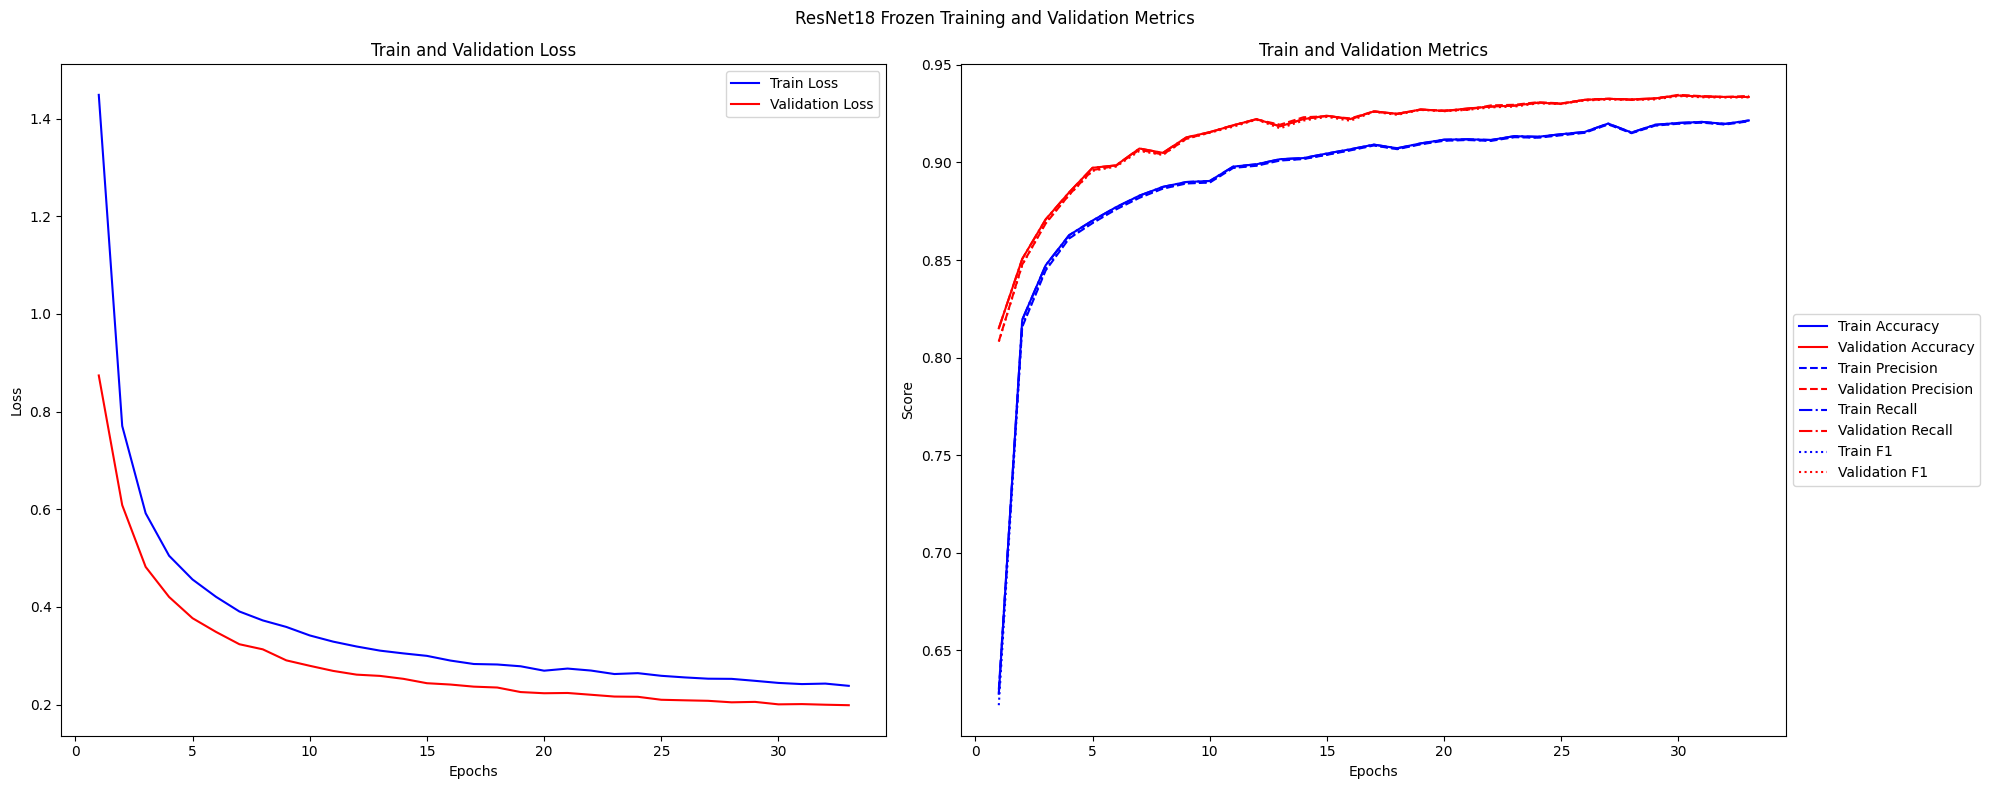

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x31af33160>
Traceback (most recent call last):
  File "/Users/i565833/Documents/MSc/Classes/Machine Learning Topics/Work 2 - CNN/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/i565833/Documents/MSc/Classes/Machine Learning Topics/Work 2 - CNN/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


: 

In [ ]:
# Load the pretrained model
# Use torchvision's ResNet18 model
resnet18_frozen = torchvision.models.resnet18(pretrained=True)
resnet18_frozen.fc = nn.Linear(resnet18_frozen.fc.in_features, 10)

epochs = 40

# Freeze all layers except the last one
for param in resnet18_frozen.parameters():
    param.requires_grad = False
for param in resnet18_frozen.fc.parameters():
    param.requires_grad = True
# Set the optimizer to only update the last layer
resnet18_frozen_optimizer = torch.optim.AdamW(resnet18_frozen.fc.parameters(), lr=1e-4, weight_decay=1e-2)


resnet18_frozen_trainer = Trainer(
    model=resnet18_frozen,
    dataloader=data_loaders,
    epochs=epochs,
    best_model_filename='./best_model_resnet18_frozen.pth',
    best_model_path=f"./models",
    optimizer=resnet18_frozen_optimizer,
)
resnet18_frozen_trainer.fit()
history = resnet18_frozen_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

resnet18_frozen_trainer.plot_metrics(title="ResNet18 Frozen Training and Validation Metrics")
resnet18_frozen_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_resnet18_frozen_df = pd.DataFrame(resnet18_frozen_trainer.history)
metrics_resnet18_frozen_df.to_csv('./metrics/metrics_resnet18_frozen.csv', index=False)

# Fine-Tuning Image Classifier - ResNet18 Gradual Unfreeze (Last/All) (LP-FT)

Using device: mps
Number of classes: 8
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:52<00:00, 11.34batch/s, loss=1.45]


Epoch 1 - Train Loss: 1.4546 - Train Accuracy: 0.6152 - Train F1: 0.6042 - Train Precision: 0.6095 - Train Recall: 0.6152


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.09batch/s, loss=0.902]


Epoch 1 - Val Loss: 0.8880 - Val Accuracy: 0.8175 - Val F1: 0.8133 - Val Precision: 0.8159 - Val Recall: 0.8175
Validation loss improved from inf to 0.8880.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:48<00:00, 12.26batch/s, loss=0.786]


Epoch 2 - Train Loss: 0.7860 - Train Accuracy: 0.8153 - Train F1: 0.8120 - Train Precision: 0.8112 - Train Recall: 0.8153


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.13batch/s, loss=0.609]


Epoch 1 - Val Loss: 0.5960 - Val Accuracy: 0.8672 - Val F1: 0.8654 - Val Precision: 0.8654 - Val Recall: 0.8672
Validation loss improved from 0.8880 to 0.5960.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:49<00:00, 11.99batch/s, loss=0.599]


Epoch 3 - Train Loss: 0.5992 - Train Accuracy: 0.8439 - Train F1: 0.8418 - Train Precision: 0.8412 - Train Recall: 0.8439


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.49] 


Epoch 1 - Val Loss: 0.4798 - Val Accuracy: 0.8807 - Val F1: 0.8789 - Val Precision: 0.8790 - Val Recall: 0.8807
Validation loss improved from 0.5960 to 0.4798.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:49<00:00, 12.05batch/s, loss=0.509]


Epoch 4 - Train Loss: 0.5094 - Train Accuracy: 0.8617 - Train F1: 0.8602 - Train Precision: 0.8599 - Train Recall: 0.8617


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.07batch/s, loss=0.428]


Epoch 1 - Val Loss: 0.4164 - Val Accuracy: 0.8899 - Val F1: 0.8889 - Val Precision: 0.8902 - Val Recall: 0.8899
Validation loss improved from 0.4798 to 0.4164.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:49<00:00, 12.03batch/s, loss=0.458]


Epoch 5 - Train Loss: 0.4577 - Train Accuracy: 0.8687 - Train F1: 0.8677 - Train Precision: 0.8673 - Train Recall: 0.8687


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.10batch/s, loss=0.381]


Epoch 1 - Val Loss: 0.3714 - Val Accuracy: 0.9010 - Val F1: 0.9003 - Val Precision: 0.9006 - Val Recall: 0.9010
Validation loss improved from 0.4164 to 0.3714.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth
Unfreezing all layers...


Train Epoch 6/40: 100%|██████████| 591/591 [01:43<00:00,  5.72batch/s, loss=0.178]


Epoch 6 - Train Loss: 0.1780 - Train Accuracy: 0.9407 - Train F1: 0.9407 - Train Precision: 0.9407 - Train Recall: 0.9407


Val Epoch 1/40: 100%|██████████| 127/127 [00:34<00:00,  3.66batch/s, loss=0.102]


Epoch 1 - Val Loss: 0.0978 - Val Accuracy: 0.9669 - Val F1: 0.9669 - Val Precision: 0.9676 - Val Recall: 0.9669
Validation loss improved from 0.3714 to 0.0978.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth


Train Epoch 7/40: 100%|██████████| 591/591 [01:44<00:00,  5.63batch/s, loss=0.0731]


Epoch 7 - Train Loss: 0.0731 - Train Accuracy: 0.9746 - Train F1: 0.9746 - Train Precision: 0.9746 - Train Recall: 0.9746


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.04batch/s, loss=0.107] 


Epoch 1 - Val Loss: 0.1028 - Val Accuracy: 0.9701 - Val F1: 0.9700 - Val Precision: 0.9715 - Val Recall: 0.9701
Validation loss did not improve from 0.0978 to 0.1028.
Early stop counter: 1/3


Train Epoch 8/40: 100%|██████████| 591/591 [01:37<00:00,  6.08batch/s, loss=0.0516]


Epoch 8 - Train Loss: 0.0516 - Train Accuracy: 0.9829 - Train F1: 0.9829 - Train Precision: 0.9829 - Train Recall: 0.9829


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.16batch/s, loss=0.0809]


Epoch 1 - Val Loss: 0.0773 - Val Accuracy: 0.9733 - Val F1: 0.9732 - Val Precision: 0.9736 - Val Recall: 0.9733
Validation loss improved from 0.0978 to 0.0773.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth


Train Epoch 9/40: 100%|██████████| 591/591 [01:37<00:00,  6.04batch/s, loss=0.0368]


Epoch 9 - Train Loss: 0.0368 - Train Accuracy: 0.9874 - Train F1: 0.9874 - Train Precision: 0.9874 - Train Recall: 0.9874


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.20batch/s, loss=0.0856]


Epoch 1 - Val Loss: 0.0818 - Val Accuracy: 0.9741 - Val F1: 0.9741 - Val Precision: 0.9748 - Val Recall: 0.9741
Validation loss did not improve from 0.0773 to 0.0818.
Early stop counter: 1/3


Train Epoch 10/40: 100%|██████████| 591/591 [01:37<00:00,  6.06batch/s, loss=0.0315]


Epoch 10 - Train Loss: 0.0315 - Train Accuracy: 0.9893 - Train F1: 0.9893 - Train Precision: 0.9893 - Train Recall: 0.9893


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.13batch/s, loss=0.0736]


Epoch 1 - Val Loss: 0.0712 - Val Accuracy: 0.9785 - Val F1: 0.9785 - Val Precision: 0.9789 - Val Recall: 0.9785
Validation loss improved from 0.0773 to 0.0712.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet18_gradual_unfreeze.pth


Train Epoch 11/40: 100%|██████████| 591/591 [01:37<00:00,  6.09batch/s, loss=0.03]   


Epoch 11 - Train Loss: 0.0300 - Train Accuracy: 0.9903 - Train F1: 0.9903 - Train Precision: 0.9903 - Train Recall: 0.9903


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.21batch/s, loss=0.0756]


Epoch 1 - Val Loss: 0.0721 - Val Accuracy: 0.9807 - Val F1: 0.9808 - Val Precision: 0.9809 - Val Recall: 0.9807
Validation loss did not improve from 0.0712 to 0.0721.
Early stop counter: 1/3


Train Epoch 12/40: 100%|██████████| 591/591 [01:37<00:00,  6.09batch/s, loss=0.0334]


Epoch 12 - Train Loss: 0.0334 - Train Accuracy: 0.9886 - Train F1: 0.9886 - Train Precision: 0.9886 - Train Recall: 0.9886


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.15batch/s, loss=0.0885]


Epoch 1 - Val Loss: 0.0843 - Val Accuracy: 0.9748 - Val F1: 0.9748 - Val Precision: 0.9753 - Val Recall: 0.9748
Validation loss did not improve from 0.0712 to 0.0843.
Early stop counter: 2/3


Train Epoch 13/40: 100%|██████████| 591/591 [01:37<00:00,  6.09batch/s, loss=0.0156] 


Epoch 13 - Train Loss: 0.0156 - Train Accuracy: 0.9949 - Train F1: 0.9949 - Train Precision: 0.9949 - Train Recall: 0.9949


Val Epoch 1/40: 100%|██████████| 127/127 [00:33<00:00,  3.74batch/s, loss=0.0939]


Epoch 1 - Val Loss: 0.0899 - Val Accuracy: 0.9763 - Val F1: 0.9762 - Val Precision: 0.9764 - Val Recall: 0.9763
Validation loss did not improve from 0.0712 to 0.0899.
Early stop counter: 3/3
Early stopping triggered at epoch 13.


Test Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.19batch/s, loss=0.0918]

Test loss: 0.08822871678811085 accuracy: 0.9765432098765432 precision: 0.9766866341400553 recall: 0.9765432098765432 f1: 0.976505551669212


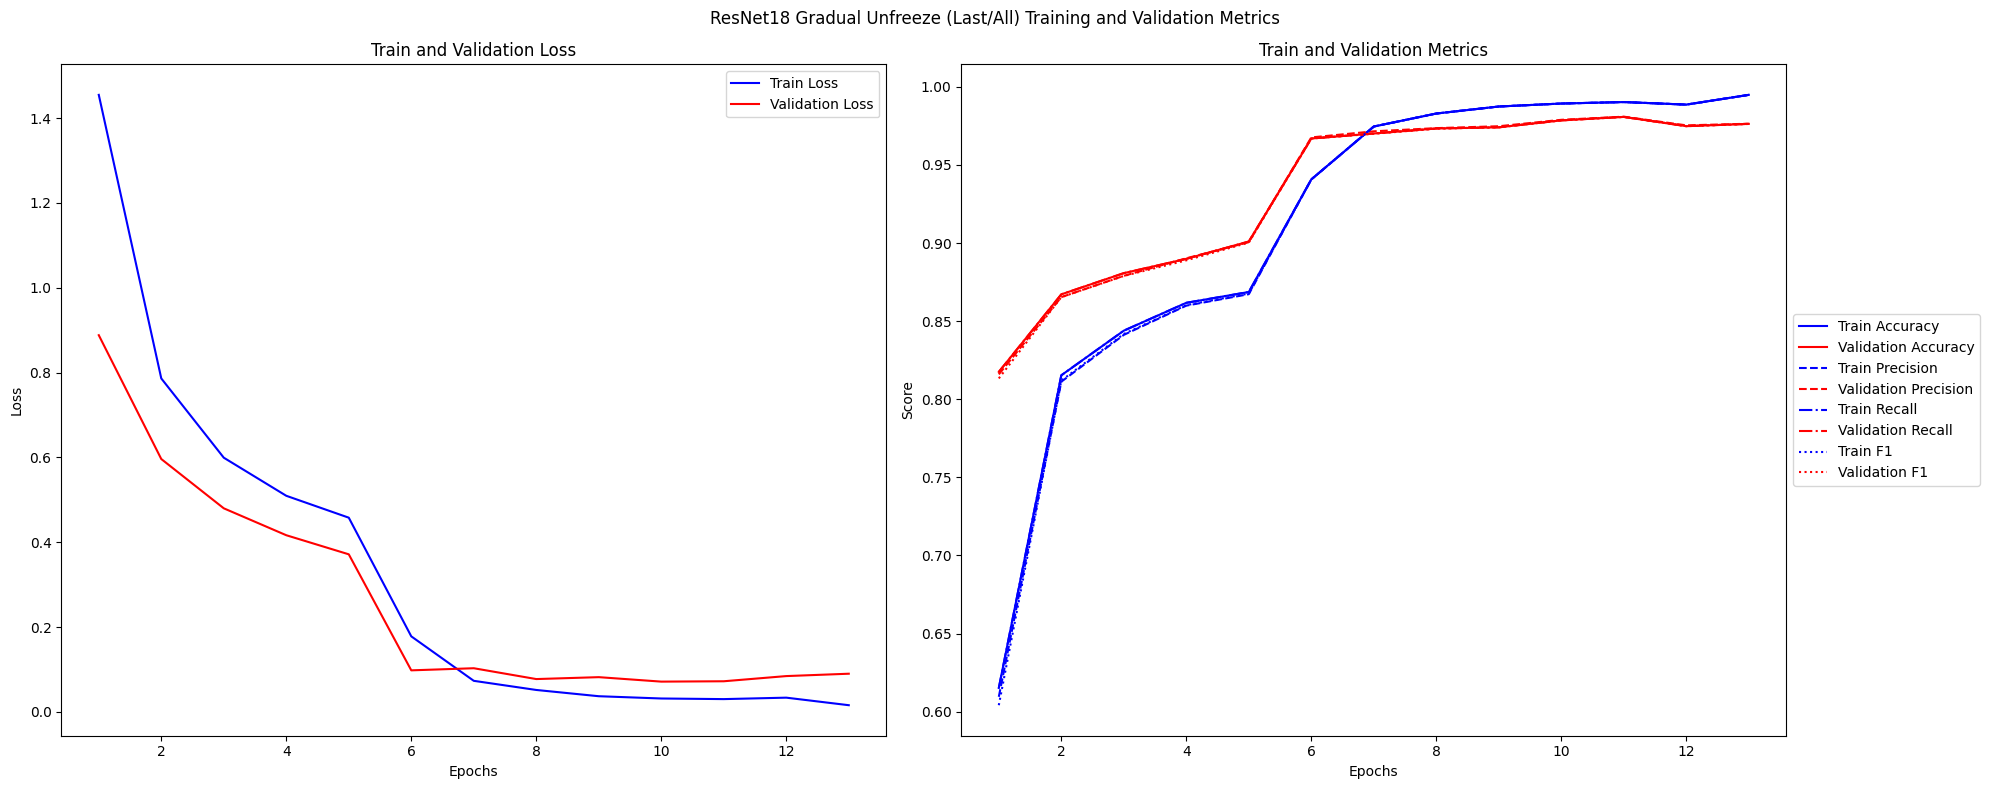

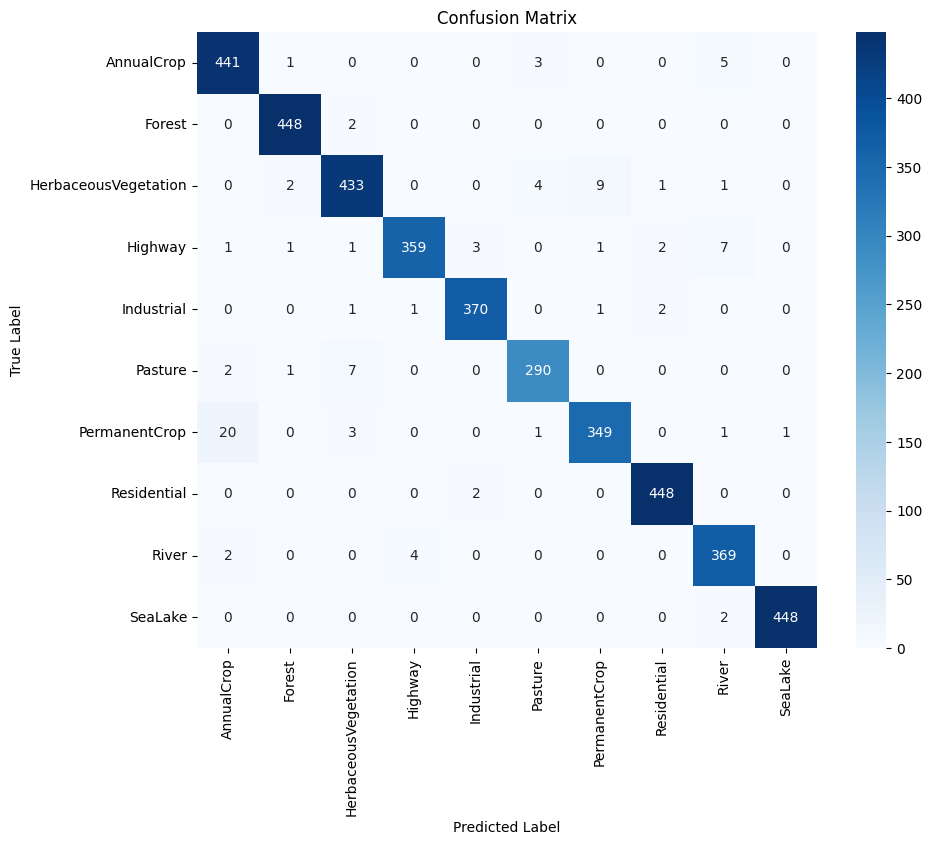

In [ ]:
# Load the pretrained model
# Use torchvision's ResNet18 model
resnet18_gradual_unfreeze = torchvision.models.resnet18(pretrained=True)
resnet18_gradual_unfreeze.fc = nn.Linear(resnet18_gradual_unfreeze.fc.in_features, 10)

epochs = 40

resnet18_gradual_unfreeze_trainer = Trainer(
    model=resnet18_gradual_unfreeze,
    dataloader=data_loaders,
    epochs=epochs,
    best_model_filename='./best_model_resnet18_gradual_unfreeze.pth',
    best_model_path=f"./models",
    learning_rate=1e-4,
    gradual_unfreeze=True,
)

resnet18_gradual_unfreeze_trainer.fit()
history = resnet18_gradual_unfreeze_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

resnet18_gradual_unfreeze_trainer.plot_metrics(title="ResNet18 Gradual Unfreeze (Last/All) Training and Validation Metrics")
resnet18_gradual_unfreeze_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_resnet18_gradual_unfreeze_df = pd.DataFrame(resnet18_gradual_unfreeze_trainer.history)
metrics_resnet18_gradual_unfreeze_df.to_csv('./metrics/metrics_resnet18_gradual_unfreeze.csv', index=False)

# Fine-Tuning Image Classifier - ResNet50 Full Parameters

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Using device: cuda
Number of classes: 9
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.238]


Epoch 1 - Train Loss: 0.2383 - Train Accuracy: 0.9247 - Train F1: 0.9246 - Train Precision: 0.9247 - Train Recall: 0.9247


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.31batch/s, loss=0.0823]


Epoch 1 - Val Loss: 0.0799 - Val Accuracy: 0.9758 - Val F1: 0.9758 - Val Precision: 0.9759 - Val Recall: 0.9758
Validation loss improved from inf to 0.0799.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 2/40: 100%|██████████| 591/591 [02:11<00:00,  4.51batch/s, loss=0.12] 


Epoch 2 - Train Loss: 0.1201 - Train Accuracy: 0.9604 - Train F1: 0.9604 - Train Precision: 0.9604 - Train Recall: 0.9604


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.21batch/s, loss=0.114]


Epoch 1 - Val Loss: 0.1092 - Val Accuracy: 0.9672 - Val F1: 0.9669 - Val Precision: 0.9683 - Val Recall: 0.9672
Validation loss did not improve from 0.0799 to 0.1092.
Early stop counter: 1/3


Train Epoch 3/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.072] 


Epoch 3 - Train Loss: 0.0720 - Train Accuracy: 0.9772 - Train F1: 0.9772 - Train Precision: 0.9772 - Train Recall: 0.9772


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.23batch/s, loss=0.0968]


Epoch 1 - Val Loss: 0.0972 - Val Accuracy: 0.9667 - Val F1: 0.9666 - Val Precision: 0.9673 - Val Recall: 0.9667
Validation loss did not improve from 0.0799 to 0.0972.
Early stop counter: 2/3


Train Epoch 4/40: 100%|██████████| 591/591 [02:11<00:00,  4.51batch/s, loss=0.0551]


Epoch 4 - Train Loss: 0.0551 - Train Accuracy: 0.9831 - Train F1: 0.9831 - Train Precision: 0.9831 - Train Recall: 0.9831


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.24batch/s, loss=0.109]


Epoch 1 - Val Loss: 0.1038 - Val Accuracy: 0.9659 - Val F1: 0.9659 - Val Precision: 0.9667 - Val Recall: 0.9659
Validation loss did not improve from 0.0799 to 0.1038.
Early stop counter: 3/3
Early stopping triggered at epoch 4.


Test Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.21batch/s, loss=0.107]


Test loss: 0.10260970376739137 accuracy: 0.9674074074074074 precision: 0.9683250391262581 recall: 0.9674074074074074 f1: 0.9674149569285807


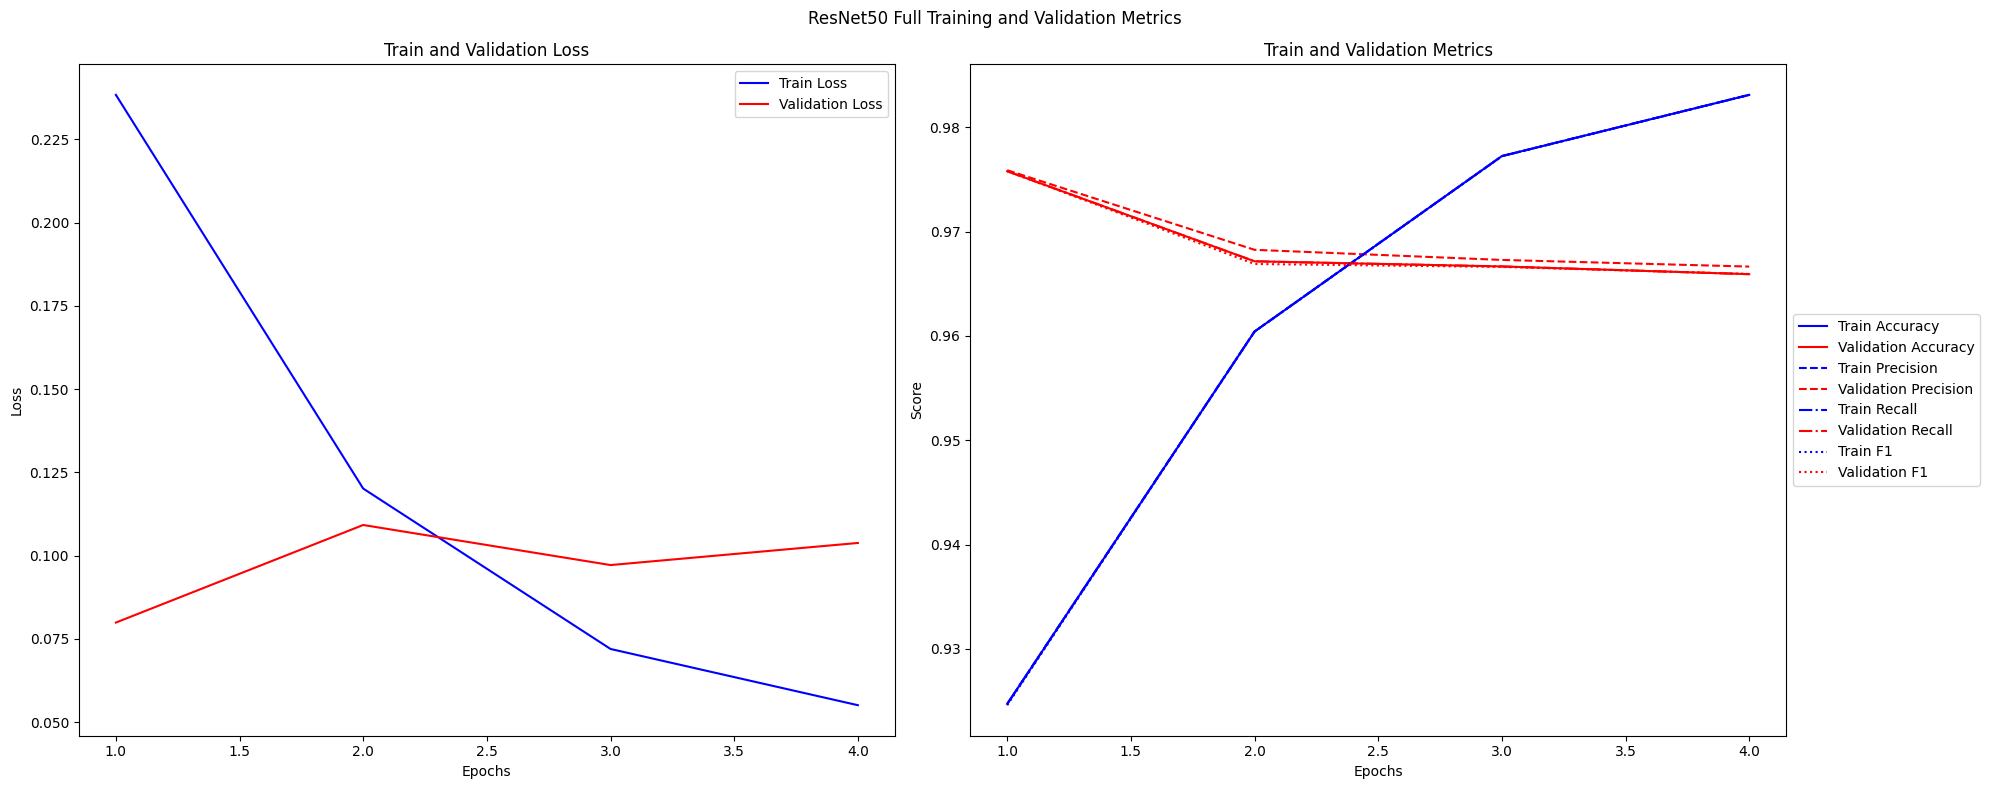

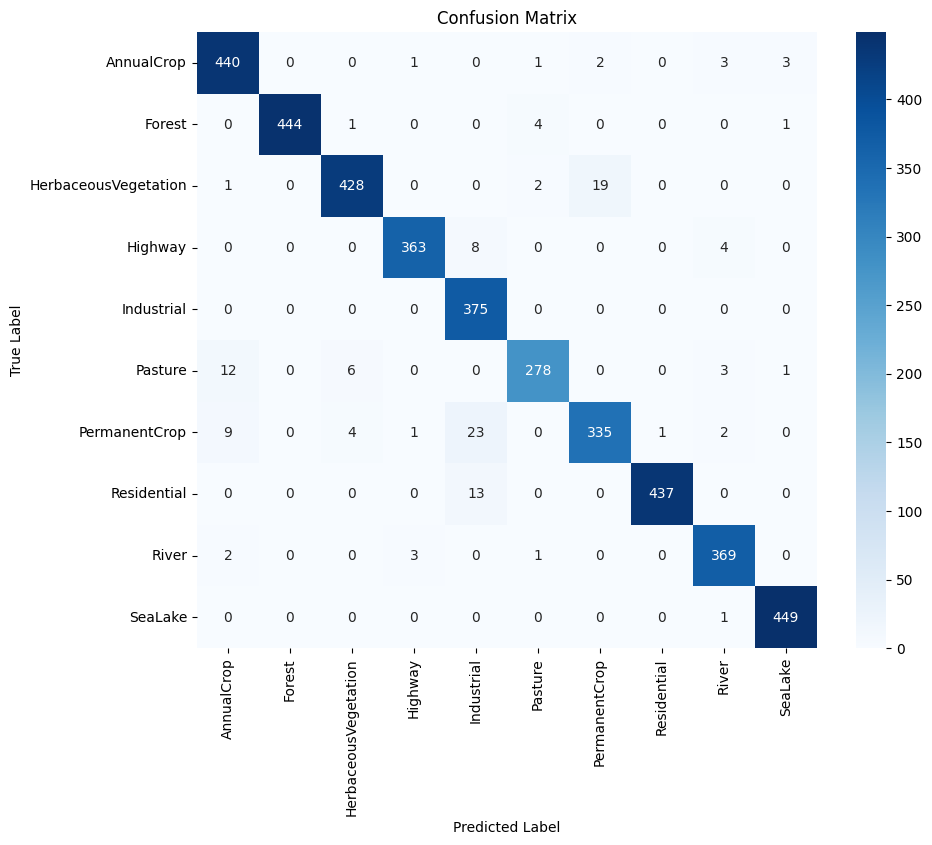

In [ ]:
# Load the pretrained model
# Use torchvision's ResNet50 model
resnet50_full = torchvision.models.resnet50(pretrained=True)
resnet50_full.fc = nn.Linear(resnet50_full.fc.in_features, 10)

epochs = 40

resnet50_full_trainer = Trainer(
    model=resnet50_full,
    dataloader=data_loaders,
    epochs=40,
    best_model_filename='./best_model_resnet50_full.pth',
    best_model_path=f"./models",
    learning_rate=1e-4
)

resnet50_full_trainer.fit()
history = resnet50_full_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

resnet50_full_trainer.plot_metrics(title="ResNet50 Full Training and Validation Metrics")
resnet50_full_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_resnet50_full_df = pd.DataFrame(resnet50_full_trainer.history)
metrics_resnet50_full_df.to_csv('./metrics/metrics_resnet50_full.csv', index=False)

# Fine-Tuning Image Classifier - ResNet50 Frozen Parameters

Using device: cuda
Number of classes: 10
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:49<00:00, 11.94batch/s, loss=1.19]


Epoch 1 - Train Loss: 1.1928 - Train Accuracy: 0.7270 - Train F1: 0.7208 - Train Precision: 0.7289 - Train Recall: 0.7270


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.33batch/s, loss=0.667]


Epoch 1 - Val Loss: 0.6475 - Val Accuracy: 0.8652 - Val F1: 0.8626 - Val Precision: 0.8634 - Val Recall: 0.8652
Validation loss improved from inf to 0.6475.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:50<00:00, 11.82batch/s, loss=0.598]


Epoch 2 - Train Loss: 0.5977 - Train Accuracy: 0.8574 - Train F1: 0.8555 - Train Precision: 0.8553 - Train Recall: 0.8574


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.23batch/s, loss=0.467]


Epoch 1 - Val Loss: 0.4527 - Val Accuracy: 0.8859 - Val F1: 0.8844 - Val Precision: 0.8868 - Val Recall: 0.8859
Validation loss improved from 0.6475 to 0.4527.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:49<00:00, 11.85batch/s, loss=0.466]


Epoch 3 - Train Loss: 0.4665 - Train Accuracy: 0.8746 - Train F1: 0.8734 - Train Precision: 0.8732 - Train Recall: 0.8746


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.30batch/s, loss=0.379]


Epoch 1 - Val Loss: 0.3652 - Val Accuracy: 0.8980 - Val F1: 0.8963 - Val Precision: 0.8968 - Val Recall: 0.8980
Validation loss improved from 0.4527 to 0.3652.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:49<00:00, 11.85batch/s, loss=0.404]


Epoch 4 - Train Loss: 0.4043 - Train Accuracy: 0.8858 - Train F1: 0.8850 - Train Precision: 0.8848 - Train Recall: 0.8858


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.28batch/s, loss=0.331]


Epoch 1 - Val Loss: 0.3200 - Val Accuracy: 0.9114 - Val F1: 0.9104 - Val Precision: 0.9110 - Val Recall: 0.9114
Validation loss improved from 0.3652 to 0.3200.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:49<00:00, 11.86batch/s, loss=0.366]


Epoch 5 - Train Loss: 0.3656 - Train Accuracy: 0.8939 - Train F1: 0.8932 - Train Precision: 0.8929 - Train Recall: 0.8939


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.21batch/s, loss=0.309]


Epoch 1 - Val Loss: 0.2972 - Val Accuracy: 0.9151 - Val F1: 0.9145 - Val Precision: 0.9157 - Val Recall: 0.9151
Validation loss improved from 0.3200 to 0.2972.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 6/40: 100%|██████████| 591/591 [00:49<00:00, 11.86batch/s, loss=0.337]


Epoch 6 - Train Loss: 0.3366 - Train Accuracy: 0.8987 - Train F1: 0.8981 - Train Precision: 0.8978 - Train Recall: 0.8987


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.29batch/s, loss=0.28] 


Epoch 1 - Val Loss: 0.2697 - Val Accuracy: 0.9222 - Val F1: 0.9216 - Val Precision: 0.9222 - Val Recall: 0.9222
Validation loss improved from 0.2972 to 0.2697.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 7/40: 100%|██████████| 591/591 [00:49<00:00, 11.87batch/s, loss=0.311]


Epoch 7 - Train Loss: 0.3111 - Train Accuracy: 0.9066 - Train F1: 0.9061 - Train Precision: 0.9061 - Train Recall: 0.9066


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.23batch/s, loss=0.267]


Epoch 1 - Val Loss: 0.2578 - Val Accuracy: 0.9230 - Val F1: 0.9224 - Val Precision: 0.9235 - Val Recall: 0.9230
Validation loss improved from 0.2697 to 0.2578.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 8/40: 100%|██████████| 591/591 [00:49<00:00, 11.87batch/s, loss=0.299]


Epoch 8 - Train Loss: 0.2989 - Train Accuracy: 0.9078 - Train F1: 0.9074 - Train Precision: 0.9072 - Train Recall: 0.9078


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.27batch/s, loss=0.254]


Epoch 1 - Val Loss: 0.2454 - Val Accuracy: 0.9274 - Val F1: 0.9271 - Val Precision: 0.9280 - Val Recall: 0.9274
Validation loss improved from 0.2578 to 0.2454.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 9/40: 100%|██████████| 591/591 [00:49<00:00, 11.84batch/s, loss=0.287]


Epoch 9 - Train Loss: 0.2865 - Train Accuracy: 0.9103 - Train F1: 0.9099 - Train Precision: 0.9097 - Train Recall: 0.9103


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.29batch/s, loss=0.244]


Epoch 1 - Val Loss: 0.2354 - Val Accuracy: 0.9269 - Val F1: 0.9266 - Val Precision: 0.9278 - Val Recall: 0.9269
Validation loss improved from 0.2454 to 0.2354.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 10/40: 100%|██████████| 591/591 [00:49<00:00, 11.86batch/s, loss=0.278]


Epoch 10 - Train Loss: 0.2781 - Train Accuracy: 0.9124 - Train F1: 0.9120 - Train Precision: 0.9119 - Train Recall: 0.9124


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.30batch/s, loss=0.235]


Epoch 1 - Val Loss: 0.2257 - Val Accuracy: 0.9277 - Val F1: 0.9273 - Val Precision: 0.9275 - Val Recall: 0.9277
Validation loss improved from 0.2354 to 0.2257.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 11/40: 100%|██████████| 591/591 [00:49<00:00, 11.85batch/s, loss=0.267]


Epoch 11 - Train Loss: 0.2672 - Train Accuracy: 0.9146 - Train F1: 0.9143 - Train Precision: 0.9142 - Train Recall: 0.9146


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.31batch/s, loss=0.229]


Epoch 1 - Val Loss: 0.2201 - Val Accuracy: 0.9301 - Val F1: 0.9298 - Val Precision: 0.9305 - Val Recall: 0.9301
Validation loss improved from 0.2257 to 0.2201.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 12/40: 100%|██████████| 591/591 [00:49<00:00, 11.87batch/s, loss=0.258]


Epoch 12 - Train Loss: 0.2585 - Train Accuracy: 0.9165 - Train F1: 0.9162 - Train Precision: 0.9160 - Train Recall: 0.9165


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.30batch/s, loss=0.223]


Epoch 1 - Val Loss: 0.2152 - Val Accuracy: 0.9279 - Val F1: 0.9275 - Val Precision: 0.9290 - Val Recall: 0.9279
Validation loss improved from 0.2201 to 0.2152.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 13/40: 100%|██████████| 591/591 [00:49<00:00, 11.87batch/s, loss=0.255]


Epoch 13 - Train Loss: 0.2549 - Train Accuracy: 0.9183 - Train F1: 0.9180 - Train Precision: 0.9179 - Train Recall: 0.9183


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.34batch/s, loss=0.219]


Epoch 1 - Val Loss: 0.2103 - Val Accuracy: 0.9326 - Val F1: 0.9324 - Val Precision: 0.9331 - Val Recall: 0.9326
Validation loss improved from 0.2152 to 0.2103.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 14/40: 100%|██████████| 591/591 [00:49<00:00, 11.88batch/s, loss=0.251]


Epoch 14 - Train Loss: 0.2513 - Train Accuracy: 0.9192 - Train F1: 0.9189 - Train Precision: 0.9188 - Train Recall: 0.9192


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.25batch/s, loss=0.219]


Epoch 1 - Val Loss: 0.2096 - Val Accuracy: 0.9343 - Val F1: 0.9339 - Val Precision: 0.9355 - Val Recall: 0.9343
Validation loss did not improve from 0.2103 to 0.2096.
Early stop counter: 1/3


Train Epoch 15/40: 100%|██████████| 591/591 [00:50<00:00, 11.80batch/s, loss=0.245]


Epoch 15 - Train Loss: 0.2448 - Train Accuracy: 0.9197 - Train F1: 0.9194 - Train Precision: 0.9193 - Train Recall: 0.9197


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.20batch/s, loss=0.218]


Epoch 1 - Val Loss: 0.2092 - Val Accuracy: 0.9331 - Val F1: 0.9327 - Val Precision: 0.9342 - Val Recall: 0.9331
Validation loss did not improve from 0.2103 to 0.2092.
Early stop counter: 2/3


Train Epoch 16/40: 100%|██████████| 591/591 [00:49<00:00, 11.82batch/s, loss=0.239]


Epoch 16 - Train Loss: 0.2394 - Train Accuracy: 0.9238 - Train F1: 0.9236 - Train Precision: 0.9235 - Train Recall: 0.9238


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.27batch/s, loss=0.21] 


Epoch 1 - Val Loss: 0.2019 - Val Accuracy: 0.9341 - Val F1: 0.9335 - Val Precision: 0.9345 - Val Recall: 0.9341
Validation loss improved from 0.2103 to 0.2019.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 17/40: 100%|██████████| 591/591 [00:49<00:00, 11.86batch/s, loss=0.237]


Epoch 17 - Train Loss: 0.2371 - Train Accuracy: 0.9218 - Train F1: 0.9216 - Train Precision: 0.9215 - Train Recall: 0.9218


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.31batch/s, loss=0.207]


Epoch 1 - Val Loss: 0.1990 - Val Accuracy: 0.9351 - Val F1: 0.9346 - Val Precision: 0.9352 - Val Recall: 0.9351
Validation loss improved from 0.2019 to 0.1990.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 18/40: 100%|██████████| 591/591 [00:49<00:00, 11.83batch/s, loss=0.235]


Epoch 18 - Train Loss: 0.2347 - Train Accuracy: 0.9221 - Train F1: 0.9218 - Train Precision: 0.9217 - Train Recall: 0.9221


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.32batch/s, loss=0.201]


Epoch 1 - Val Loss: 0.1932 - Val Accuracy: 0.9405 - Val F1: 0.9402 - Val Precision: 0.9410 - Val Recall: 0.9405
Validation loss improved from 0.1990 to 0.1932.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 19/40: 100%|██████████| 591/591 [00:49<00:00, 11.88batch/s, loss=0.229]


Epoch 19 - Train Loss: 0.2294 - Train Accuracy: 0.9251 - Train F1: 0.9249 - Train Precision: 0.9249 - Train Recall: 0.9251


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.33batch/s, loss=0.2]  


Epoch 1 - Val Loss: 0.1923 - Val Accuracy: 0.9368 - Val F1: 0.9364 - Val Precision: 0.9366 - Val Recall: 0.9368
Validation loss did not improve from 0.1932 to 0.1923.
Early stop counter: 1/3


Train Epoch 20/40: 100%|██████████| 591/591 [00:49<00:00, 11.90batch/s, loss=0.223]


Epoch 20 - Train Loss: 0.2230 - Train Accuracy: 0.9278 - Train F1: 0.9275 - Train Precision: 0.9274 - Train Recall: 0.9278


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.30batch/s, loss=0.198]


Epoch 1 - Val Loss: 0.1907 - Val Accuracy: 0.9370 - Val F1: 0.9367 - Val Precision: 0.9381 - Val Recall: 0.9370
Validation loss improved from 0.1932 to 0.1907.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 21/40: 100%|██████████| 591/591 [00:49<00:00, 11.87batch/s, loss=0.221]


Epoch 21 - Train Loss: 0.2206 - Train Accuracy: 0.9288 - Train F1: 0.9286 - Train Precision: 0.9285 - Train Recall: 0.9288


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.25batch/s, loss=0.197]


Epoch 1 - Val Loss: 0.1889 - Val Accuracy: 0.9375 - Val F1: 0.9373 - Val Precision: 0.9375 - Val Recall: 0.9375
Validation loss did not improve from 0.1907 to 0.1889.
Early stop counter: 1/3


Train Epoch 22/40: 100%|██████████| 591/591 [00:49<00:00, 11.86batch/s, loss=0.218]


Epoch 22 - Train Loss: 0.2182 - Train Accuracy: 0.9291 - Train F1: 0.9290 - Train Precision: 0.9289 - Train Recall: 0.9291


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.31batch/s, loss=0.196]


Epoch 1 - Val Loss: 0.1880 - Val Accuracy: 0.9383 - Val F1: 0.9381 - Val Precision: 0.9391 - Val Recall: 0.9383
Validation loss improved from 0.1907 to 0.1880.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 23/40: 100%|██████████| 591/591 [00:49<00:00, 11.88batch/s, loss=0.214]


Epoch 23 - Train Loss: 0.2138 - Train Accuracy: 0.9319 - Train F1: 0.9317 - Train Precision: 0.9316 - Train Recall: 0.9319


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.28batch/s, loss=0.194]


Epoch 1 - Val Loss: 0.1863 - Val Accuracy: 0.9373 - Val F1: 0.9369 - Val Precision: 0.9378 - Val Recall: 0.9373
Validation loss did not improve from 0.1880 to 0.1863.
Early stop counter: 1/3


Train Epoch 24/40: 100%|██████████| 591/591 [00:49<00:00, 11.87batch/s, loss=0.217]


Epoch 24 - Train Loss: 0.2167 - Train Accuracy: 0.9277 - Train F1: 0.9275 - Train Precision: 0.9274 - Train Recall: 0.9277


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.28batch/s, loss=0.188]


Epoch 1 - Val Loss: 0.1806 - Val Accuracy: 0.9385 - Val F1: 0.9385 - Val Precision: 0.9388 - Val Recall: 0.9385
Validation loss improved from 0.1880 to 0.1806.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 25/40: 100%|██████████| 591/591 [00:49<00:00, 11.86batch/s, loss=0.212]


Epoch 25 - Train Loss: 0.2117 - Train Accuracy: 0.9310 - Train F1: 0.9308 - Train Precision: 0.9307 - Train Recall: 0.9310


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.27batch/s, loss=0.186]


Epoch 1 - Val Loss: 0.1779 - Val Accuracy: 0.9410 - Val F1: 0.9407 - Val Precision: 0.9410 - Val Recall: 0.9410
Validation loss improved from 0.1806 to 0.1779.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_frozen.pth


Train Epoch 26/40: 100%|██████████| 591/591 [00:49<00:00, 11.88batch/s, loss=0.211]


Epoch 26 - Train Loss: 0.2106 - Train Accuracy: 0.9317 - Train F1: 0.9316 - Train Precision: 0.9315 - Train Recall: 0.9317


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.29batch/s, loss=0.184]


Epoch 1 - Val Loss: 0.1767 - Val Accuracy: 0.9412 - Val F1: 0.9409 - Val Precision: 0.9416 - Val Recall: 0.9412
Validation loss did not improve from 0.1779 to 0.1767.
Early stop counter: 1/3


Train Epoch 27/40: 100%|██████████| 591/591 [00:49<00:00, 11.84batch/s, loss=0.205]


Epoch 27 - Train Loss: 0.2050 - Train Accuracy: 0.9326 - Train F1: 0.9325 - Train Precision: 0.9324 - Train Recall: 0.9326


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.22batch/s, loss=0.184]


Epoch 1 - Val Loss: 0.1764 - Val Accuracy: 0.9410 - Val F1: 0.9406 - Val Precision: 0.9412 - Val Recall: 0.9410
Validation loss did not improve from 0.1779 to 0.1764.
Early stop counter: 2/3


Train Epoch 28/40: 100%|██████████| 591/591 [00:49<00:00, 11.84batch/s, loss=0.206]


Epoch 28 - Train Loss: 0.2060 - Train Accuracy: 0.9322 - Train F1: 0.9320 - Train Precision: 0.9320 - Train Recall: 0.9322


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.28batch/s, loss=0.184]


Epoch 1 - Val Loss: 0.1762 - Val Accuracy: 0.9427 - Val F1: 0.9422 - Val Precision: 0.9425 - Val Recall: 0.9427
Validation loss did not improve from 0.1779 to 0.1762.
Early stop counter: 3/3
Early stopping triggered at epoch 28.


Test Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.32batch/s, loss=0.197]


Test loss: 0.18798653197687443 accuracy: 0.9377777777777778 precision: 0.9375407210712399 recall: 0.9377777777777778 f1: 0.9372164914344997


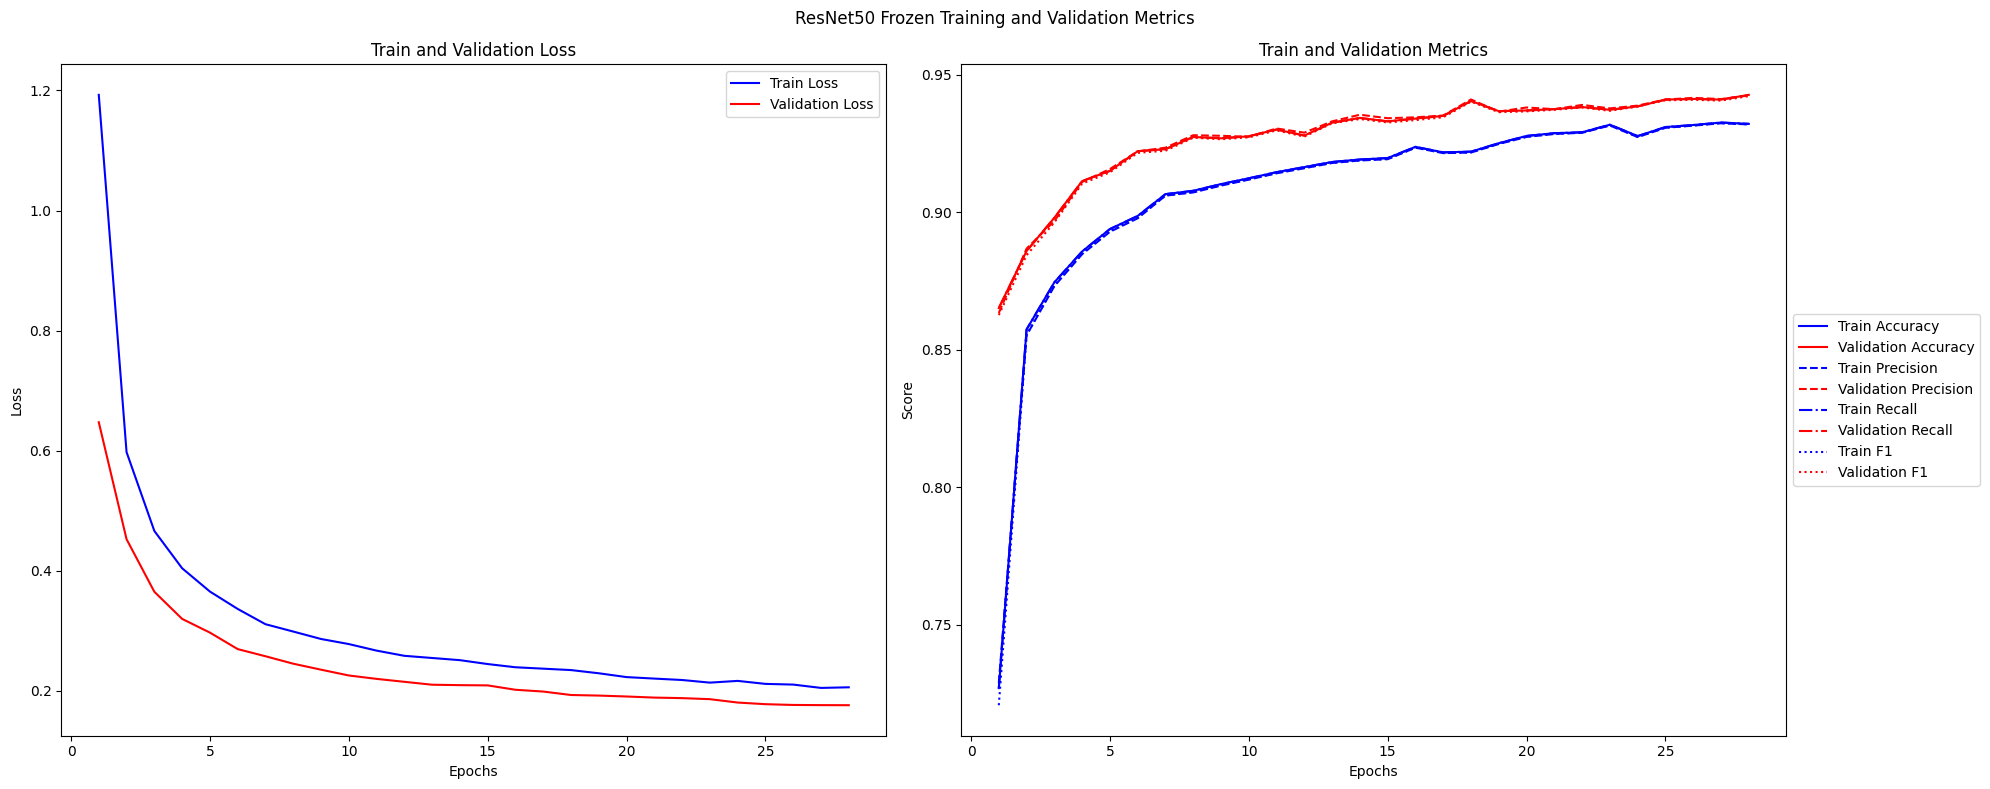

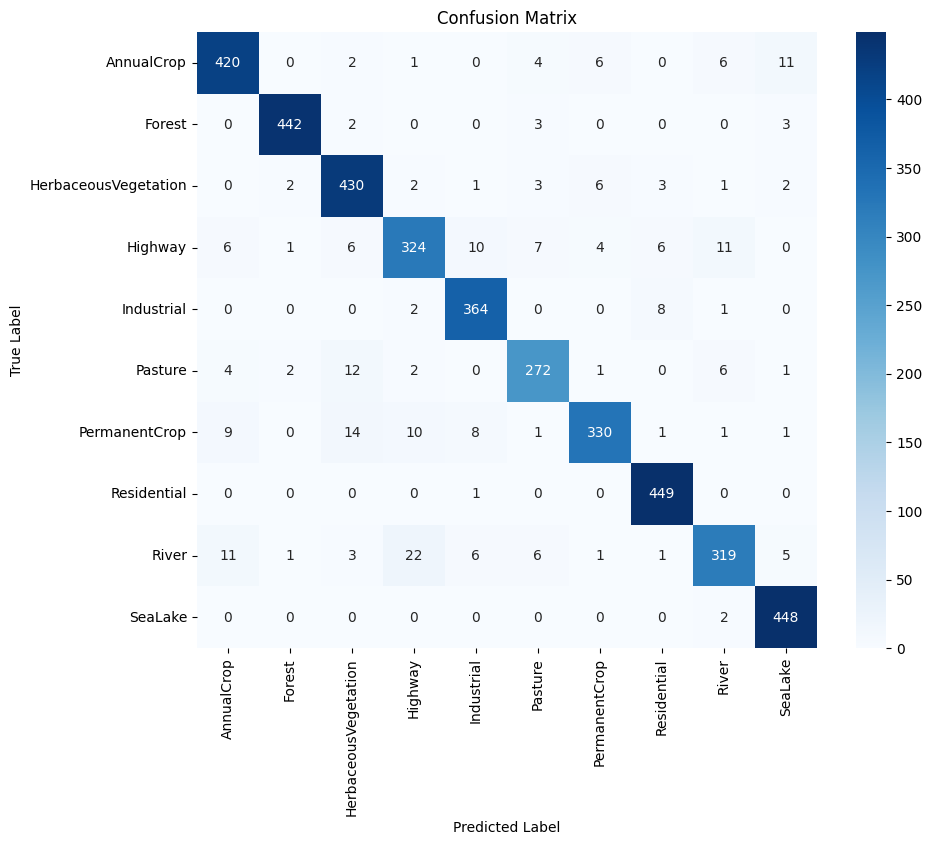

In [ ]:
# Load the pretrained model
# Use torchvision's ResNet50 model
resnet50_frozen = torchvision.models.resnet50(pretrained=True)
resnet50_frozen.fc = nn.Linear(resnet50_frozen.fc.in_features, 10)

epochs = 40

# Freeze all layers except the last one
for param in resnet50_frozen.parameters():
    param.requires_grad = False
for param in resnet50_frozen.fc.parameters():
    param.requires_grad = True
    
# Set the optimizer to only update the last layer
resnet50_frozen_optimizer = torch.optim.AdamW(resnet50_frozen.fc.parameters(), lr=1e-4, weight_decay=1e-2)

resnet50_frozen_trainer = Trainer(
    model=resnet50_frozen,
    dataloader=data_loaders,
    epochs=40,
    best_model_filename='./best_model_resnet50_frozen.pth',
    best_model_path=f"./models",
    optimizer=resnet50_frozen_optimizer,
)
resnet50_frozen_trainer.fit()
history = resnet50_frozen_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

resnet50_frozen_trainer.plot_metrics(title="ResNet50 Frozen Training and Validation Metrics")
resnet50_frozen_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_resnet50_frozen_df = pd.DataFrame(resnet50_frozen_trainer.history)
metrics_resnet50_frozen_df.to_csv('./metrics/metrics_resnet50_frozen.csv', index=False)

# Fine-Tuning Image Classifier - ResNet50 Gradual Unfreeze (Last/All) (LP-FT)

Using device: cuda
Number of classes: 10
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:50<00:00, 11.81batch/s, loss=1.17]


Epoch 1 - Train Loss: 1.1688 - Train Accuracy: 0.7406 - Train F1: 0.7349 - Train Precision: 0.7377 - Train Recall: 0.7406


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.16batch/s, loss=0.659]


Epoch 1 - Val Loss: 0.6406 - Val Accuracy: 0.8652 - Val F1: 0.8635 - Val Precision: 0.8645 - Val Recall: 0.8652
Validation loss improved from inf to 0.6406.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:49<00:00, 11.82batch/s, loss=0.595]


Epoch 2 - Train Loss: 0.5949 - Train Accuracy: 0.8587 - Train F1: 0.8567 - Train Precision: 0.8565 - Train Recall: 0.8587


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.24batch/s, loss=0.462]


Epoch 1 - Val Loss: 0.4456 - Val Accuracy: 0.8864 - Val F1: 0.8845 - Val Precision: 0.8865 - Val Recall: 0.8864
Validation loss improved from 0.6406 to 0.4456.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:50<00:00, 11.81batch/s, loss=0.461]


Epoch 3 - Train Loss: 0.4608 - Train Accuracy: 0.8784 - Train F1: 0.8772 - Train Precision: 0.8769 - Train Recall: 0.8784


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.05batch/s, loss=0.38] 


Epoch 1 - Val Loss: 0.3687 - Val Accuracy: 0.8956 - Val F1: 0.8942 - Val Precision: 0.8951 - Val Recall: 0.8956
Validation loss improved from 0.4456 to 0.3687.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:50<00:00, 11.79batch/s, loss=0.405]


Epoch 4 - Train Loss: 0.4050 - Train Accuracy: 0.8843 - Train F1: 0.8835 - Train Precision: 0.8832 - Train Recall: 0.8843


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.16batch/s, loss=0.333]


Epoch 1 - Val Loss: 0.3209 - Val Accuracy: 0.9084 - Val F1: 0.9075 - Val Precision: 0.9079 - Val Recall: 0.9084
Validation loss improved from 0.3687 to 0.3209.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:50<00:00, 11.77batch/s, loss=0.361]


Epoch 5 - Train Loss: 0.3610 - Train Accuracy: 0.8943 - Train F1: 0.8937 - Train Precision: 0.8935 - Train Recall: 0.8943


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.16batch/s, loss=0.307]


Epoch 1 - Val Loss: 0.2952 - Val Accuracy: 0.9143 - Val F1: 0.9133 - Val Precision: 0.9146 - Val Recall: 0.9143
Validation loss improved from 0.3209 to 0.2952.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth
Unfreezing all layers...


Train Epoch 6/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.197]


Epoch 6 - Train Loss: 0.1975 - Train Accuracy: 0.9326 - Train F1: 0.9326 - Train Precision: 0.9326 - Train Recall: 0.9326


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.24batch/s, loss=0.209]


Epoch 1 - Val Loss: 0.1994 - Val Accuracy: 0.9400 - Val F1: 0.9396 - Val Precision: 0.9453 - Val Recall: 0.9400
Validation loss improved from 0.2952 to 0.1994.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 7/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.0898]


Epoch 7 - Train Loss: 0.0898 - Train Accuracy: 0.9701 - Train F1: 0.9701 - Train Precision: 0.9701 - Train Recall: 0.9701


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.18batch/s, loss=0.0938]


Epoch 1 - Val Loss: 0.0931 - Val Accuracy: 0.9684 - Val F1: 0.9684 - Val Precision: 0.9689 - Val Recall: 0.9684
Validation loss improved from 0.1994 to 0.0931.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 8/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.0692]


Epoch 8 - Train Loss: 0.0692 - Train Accuracy: 0.9775 - Train F1: 0.9775 - Train Precision: 0.9775 - Train Recall: 0.9775


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.27batch/s, loss=0.0867]


Epoch 1 - Val Loss: 0.0832 - Val Accuracy: 0.9728 - Val F1: 0.9729 - Val Precision: 0.9735 - Val Recall: 0.9728
Validation loss improved from 0.0931 to 0.0832.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 9/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.0503]


Epoch 9 - Train Loss: 0.0503 - Train Accuracy: 0.9844 - Train F1: 0.9844 - Train Precision: 0.9844 - Train Recall: 0.9844


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.19batch/s, loss=0.0819]


Epoch 1 - Val Loss: 0.0783 - Val Accuracy: 0.9775 - Val F1: 0.9776 - Val Precision: 0.9777 - Val Recall: 0.9775
Validation loss improved from 0.0832 to 0.0783.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 10/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.0527]


Epoch 10 - Train Loss: 0.0527 - Train Accuracy: 0.9822 - Train F1: 0.9822 - Train Precision: 0.9822 - Train Recall: 0.9822


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.23batch/s, loss=0.0786]


Epoch 1 - Val Loss: 0.0765 - Val Accuracy: 0.9758 - Val F1: 0.9758 - Val Precision: 0.9760 - Val Recall: 0.9758
Validation loss improved from 0.0783 to 0.0765.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_resnet50_gradual_unfreeze.pth


Train Epoch 11/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.0411]


Epoch 11 - Train Loss: 0.0411 - Train Accuracy: 0.9856 - Train F1: 0.9856 - Train Precision: 0.9856 - Train Recall: 0.9856


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.16batch/s, loss=0.0819]


Epoch 1 - Val Loss: 0.0785 - Val Accuracy: 0.9790 - Val F1: 0.9790 - Val Precision: 0.9794 - Val Recall: 0.9790
Validation loss did not improve from 0.0765 to 0.0785.
Early stop counter: 1/3


Train Epoch 12/40: 100%|██████████| 591/591 [02:11<00:00,  4.50batch/s, loss=0.0308]


Epoch 12 - Train Loss: 0.0308 - Train Accuracy: 0.9896 - Train F1: 0.9896 - Train Precision: 0.9896 - Train Recall: 0.9896


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.31batch/s, loss=0.0897]


Epoch 1 - Val Loss: 0.0855 - Val Accuracy: 0.9716 - Val F1: 0.9716 - Val Precision: 0.9718 - Val Recall: 0.9716
Validation loss did not improve from 0.0765 to 0.0855.
Early stop counter: 2/3


Train Epoch 13/40: 100%|██████████| 591/591 [02:10<00:00,  4.51batch/s, loss=0.0402]


Epoch 13 - Train Loss: 0.0402 - Train Accuracy: 0.9868 - Train F1: 0.9868 - Train Precision: 0.9868 - Train Recall: 0.9868


Val Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.20batch/s, loss=0.095]


Epoch 1 - Val Loss: 0.0911 - Val Accuracy: 0.9738 - Val F1: 0.9737 - Val Precision: 0.9746 - Val Recall: 0.9738
Validation loss did not improve from 0.0765 to 0.0911.
Early stop counter: 3/3
Early stopping triggered at epoch 13.


Test Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 12.29batch/s, loss=0.0894]


Test loss: 0.08740601717979339 accuracy: 0.9725925925925926 precision: 0.9734501960736773 recall: 0.9725925925925926 f1: 0.9726078027930031


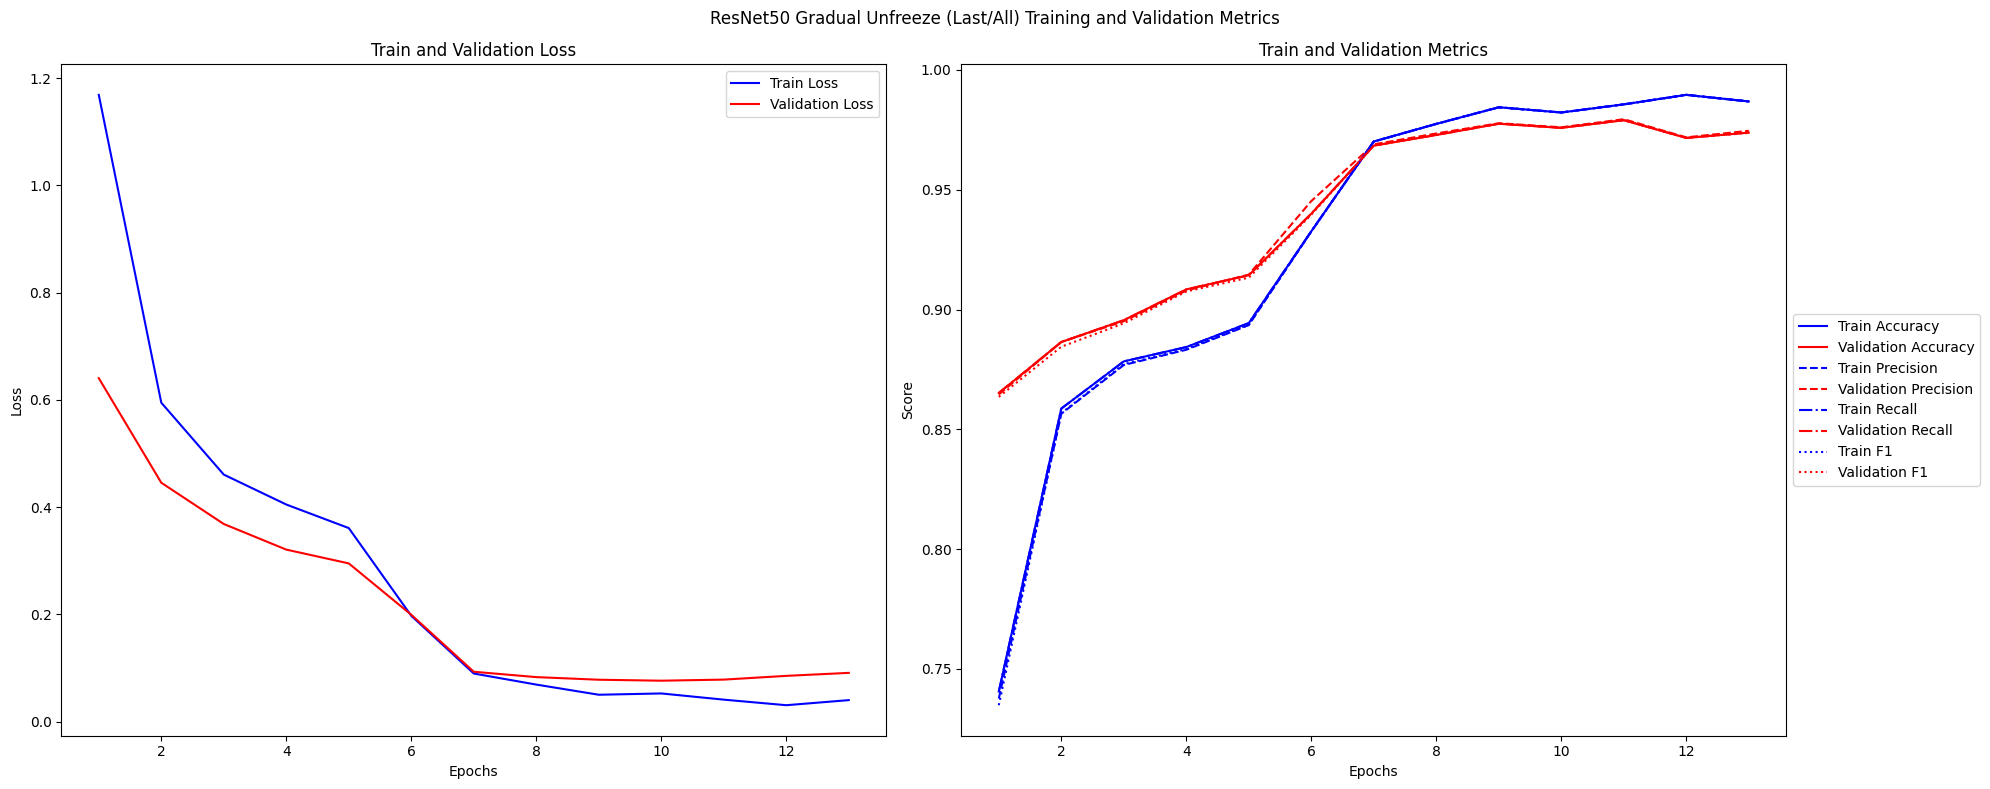

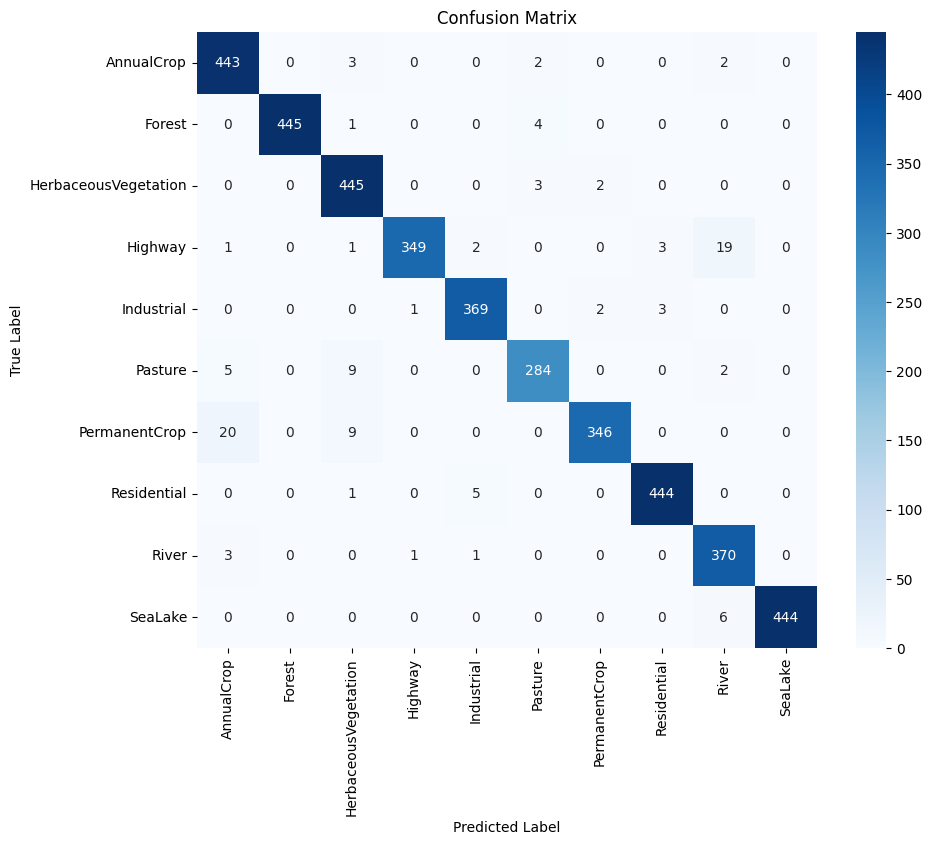

In [ ]:
# Load the pretrained model
# Use torchvision's ResNet50 model
resnet50_gradual_unfreeze = torchvision.models.resnet50(pretrained=True)
resnet50_gradual_unfreeze.fc = nn.Linear(resnet50_gradual_unfreeze.fc.in_features, 10)

epochs = 40

resnet50_gradual_unfreeze_trainer = Trainer(
    model=resnet50_gradual_unfreeze,
    dataloader=data_loaders,
    epochs=epochs,
    best_model_filename='./best_model_resnet50_gradual_unfreeze.pth',
    best_model_path=f"./models",
    learning_rate=1e-4,
    gradual_unfreeze=True,
)

resnet50_gradual_unfreeze_trainer.fit()
history = resnet50_gradual_unfreeze_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

resnet50_gradual_unfreeze_trainer.plot_metrics(title="ResNet50 Gradual Unfreeze (Last/All) Training and Validation Metrics")
resnet50_gradual_unfreeze_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_resnet50_gradual_unfreeze_df = pd.DataFrame(resnet50_gradual_unfreeze_trainer.history)
metrics_resnet50_gradual_unfreeze_df.to_csv('./metrics/metrics_resnet50_gradual_unfreeze.csv', index=False)

# Fine-Tuning Image Classifier - EfficientNetB0 Full Parameters

Using device: cuda
Number of classes: 10
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [01:27<00:00,  6.77batch/s, loss=0.377]


Epoch 1 - Train Loss: 0.3770 - Train Accuracy: 0.8990 - Train F1: 0.8988 - Train Precision: 0.8996 - Train Recall: 0.8990


Val Epoch 1/40: 100%|██████████| 127/127 [00:08<00:00, 15.01batch/s, loss=0.067] 


Epoch 1 - Val Loss: 0.0642 - Val Accuracy: 0.9815 - Val F1: 0.9815 - Val Precision: 0.9816 - Val Recall: 0.9815
Validation loss improved from inf to 0.0642.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet.pth


Train Epoch 2/40: 100%|██████████| 591/591 [01:26<00:00,  6.80batch/s, loss=0.102]


Epoch 2 - Train Loss: 0.1022 - Train Accuracy: 0.9676 - Train F1: 0.9676 - Train Precision: 0.9676 - Train Recall: 0.9676


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 19.02batch/s, loss=0.0553]


Epoch 1 - Val Loss: 0.0528 - Val Accuracy: 0.9800 - Val F1: 0.9800 - Val Precision: 0.9803 - Val Recall: 0.9800
Validation loss improved from 0.0642 to 0.0528.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet.pth


Train Epoch 3/40: 100%|██████████| 591/591 [01:26<00:00,  6.79batch/s, loss=0.0657]


Epoch 3 - Train Loss: 0.0657 - Train Accuracy: 0.9798 - Train F1: 0.9798 - Train Precision: 0.9798 - Train Recall: 0.9798


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 19.31batch/s, loss=0.0515]


Epoch 1 - Val Loss: 0.0491 - Val Accuracy: 0.9825 - Val F1: 0.9825 - Val Precision: 0.9825 - Val Recall: 0.9825
Validation loss improved from 0.0528 to 0.0491.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet.pth


Train Epoch 4/40: 100%|██████████| 591/591 [01:26<00:00,  6.80batch/s, loss=0.0466]


Epoch 4 - Train Loss: 0.0466 - Train Accuracy: 0.9856 - Train F1: 0.9856 - Train Precision: 0.9856 - Train Recall: 0.9856


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 18.97batch/s, loss=0.0467]


Epoch 1 - Val Loss: 0.0446 - Val Accuracy: 0.9847 - Val F1: 0.9847 - Val Precision: 0.9847 - Val Recall: 0.9847
Validation loss improved from 0.0491 to 0.0446.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet.pth


Train Epoch 5/40: 100%|██████████| 591/591 [01:26<00:00,  6.80batch/s, loss=0.0351]


Epoch 5 - Train Loss: 0.0351 - Train Accuracy: 0.9894 - Train F1: 0.9894 - Train Precision: 0.9894 - Train Recall: 0.9894


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 18.22batch/s, loss=0.0528]


Epoch 1 - Val Loss: 0.0503 - Val Accuracy: 0.9830 - Val F1: 0.9830 - Val Precision: 0.9830 - Val Recall: 0.9830
Validation loss did not improve from 0.0446 to 0.0503.
Early stop counter: 1/3


Train Epoch 6/40: 100%|██████████| 591/591 [01:26<00:00,  6.80batch/s, loss=0.0309]


Epoch 6 - Train Loss: 0.0309 - Train Accuracy: 0.9901 - Train F1: 0.9901 - Train Precision: 0.9901 - Train Recall: 0.9901


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 18.24batch/s, loss=0.054] 


Epoch 1 - Val Loss: 0.0515 - Val Accuracy: 0.9837 - Val F1: 0.9837 - Val Precision: 0.9839 - Val Recall: 0.9837
Validation loss did not improve from 0.0446 to 0.0515.
Early stop counter: 2/3


Train Epoch 7/40: 100%|██████████| 591/591 [01:26<00:00,  6.80batch/s, loss=0.0217]


Epoch 7 - Train Loss: 0.0217 - Train Accuracy: 0.9931 - Train F1: 0.9931 - Train Precision: 0.9931 - Train Recall: 0.9931


Val Epoch 1/40: 100%|██████████| 127/127 [00:06<00:00, 18.33batch/s, loss=0.0537]


Epoch 1 - Val Loss: 0.0512 - Val Accuracy: 0.9847 - Val F1: 0.9847 - Val Precision: 0.9848 - Val Recall: 0.9847
Validation loss did not improve from 0.0446 to 0.0512.
Early stop counter: 3/3
Early stopping triggered at epoch 7.


Test Epoch 1/40: 100%|██████████| 127/127 [00:10<00:00, 11.74batch/s, loss=0.048] 


Test loss: 0.04583590062081678 accuracy: 0.9869135802469136 precision: 0.986920062401787 recall: 0.9869135802469136 f1: 0.9869119779155872


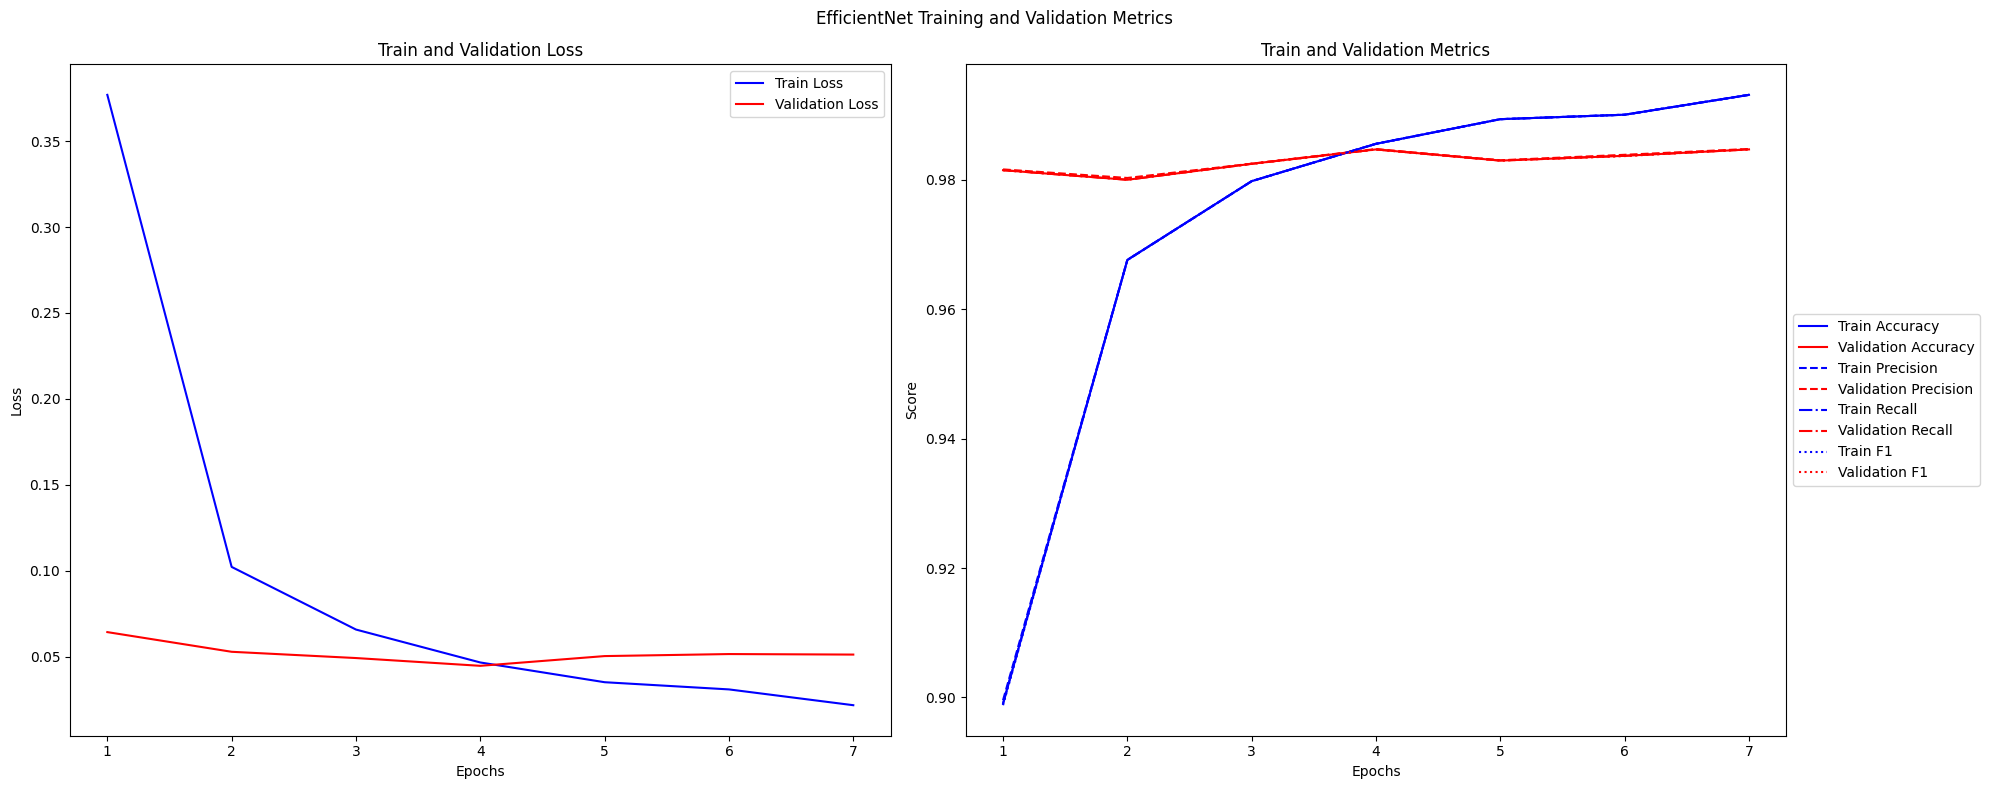

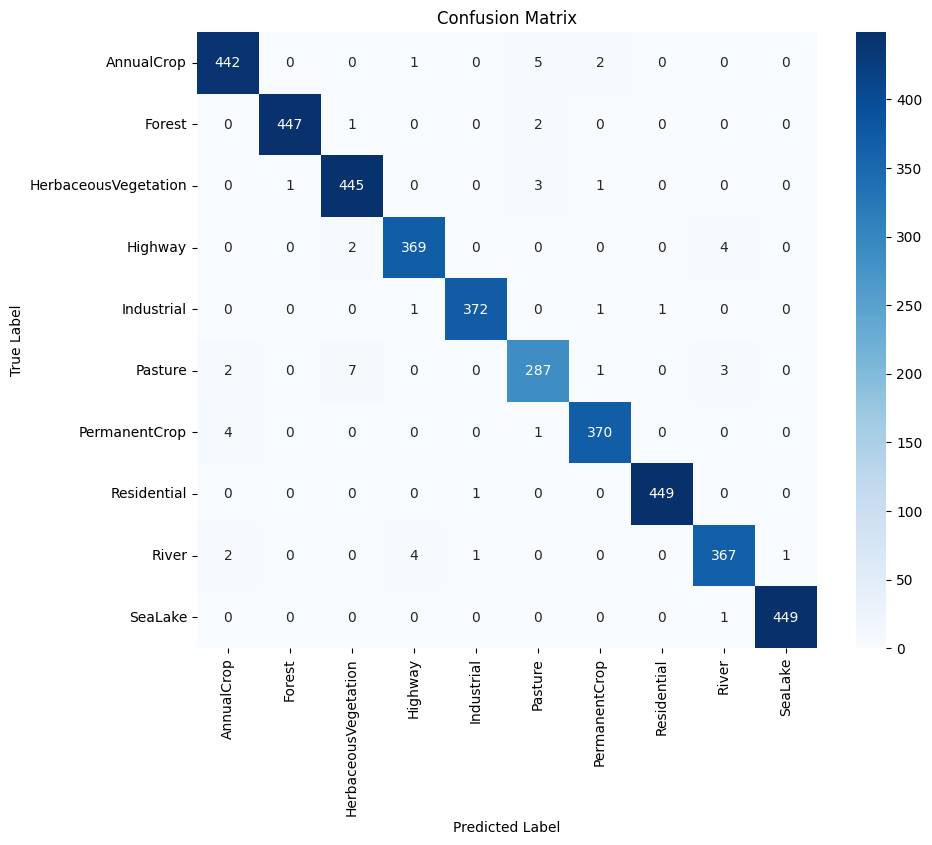

In [ ]:
efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=10)

epochs = 40

efficientnet_trainer = Trainer(
    model=efficientnet,
    dataloader=data_loaders,
    epochs=epochs,
    best_model_filename='./best_model_efficientnet.pth',
    best_model_path=f"./models",
    learning_rate=1e-4
)

efficientnet_trainer.fit()
history = efficientnet_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

efficientnet_trainer.plot_metrics(title="EfficientNet Training and Validation Metrics")
efficientnet_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_efficientnet_df = pd.DataFrame(efficientnet_trainer.history)
metrics_efficientnet_df.to_csv('./metrics/metrics_efficientnet.csv', index=False)

# Fine-Tuning Image Classifier - EfficientNet B0 Gradual Unfreeze (Last/All)

Using device: mps
Number of classes: 10
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:57<00:00, 10.27batch/s, loss=1.4] 


Epoch 1 - Train Loss: 1.3981 - Train Accuracy: 0.6894 - Train F1: 0.6862 - Train Precision: 0.6919 - Train Recall: 0.6894


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  3.98batch/s, loss=0.824]


Epoch 1 - Val Loss: 0.8235 - Val Accuracy: 0.8358 - Val F1: 0.8322 - Val Precision: 0.8372 - Val Recall: 0.8358
Validation loss improved from inf to 0.8235.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:56<00:00, 10.43batch/s, loss=0.783]


Epoch 2 - Train Loss: 0.7828 - Train Accuracy: 0.8129 - Train F1: 0.8099 - Train Precision: 0.8120 - Train Recall: 0.8129


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.00batch/s, loss=0.575]


Epoch 1 - Val Loss: 0.5698 - Val Accuracy: 0.8593 - Val F1: 0.8573 - Val Precision: 0.8593 - Val Recall: 0.8593
Validation loss improved from 0.8235 to 0.5698.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:57<00:00, 10.26batch/s, loss=0.609]


Epoch 3 - Train Loss: 0.6091 - Train Accuracy: 0.8361 - Train F1: 0.8342 - Train Precision: 0.8348 - Train Recall: 0.8361


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.03batch/s, loss=0.458]


Epoch 1 - Val Loss: 0.4521 - Val Accuracy: 0.8817 - Val F1: 0.8803 - Val Precision: 0.8815 - Val Recall: 0.8817
Validation loss improved from 0.5698 to 0.4521.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:57<00:00, 10.35batch/s, loss=0.523]


Epoch 4 - Train Loss: 0.5229 - Train Accuracy: 0.8511 - Train F1: 0.8494 - Train Precision: 0.8498 - Train Recall: 0.8511


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.03batch/s, loss=0.4]  


Epoch 1 - Val Loss: 0.3921 - Val Accuracy: 0.8896 - Val F1: 0.8885 - Val Precision: 0.8891 - Val Recall: 0.8896
Validation loss improved from 0.4521 to 0.3921.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:56<00:00, 10.49batch/s, loss=0.483]


Epoch 5 - Train Loss: 0.4831 - Train Accuracy: 0.8578 - Train F1: 0.8566 - Train Precision: 0.8566 - Train Recall: 0.8578


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.355]


Epoch 1 - Val Loss: 0.3481 - Val Accuracy: 0.9015 - Val F1: 0.9006 - Val Precision: 0.9014 - Val Recall: 0.9015
Validation loss improved from 0.3921 to 0.3481.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth
Unfreezing all layers...


Train Epoch 6/40: 100%|██████████| 591/591 [02:28<00:00,  3.97batch/s, loss=0.175]


Epoch 6 - Train Loss: 0.1754 - Train Accuracy: 0.9415 - Train F1: 0.9415 - Train Precision: 0.9415 - Train Recall: 0.9415


Val Epoch 1/40: 100%|██████████| 127/127 [00:32<00:00,  3.87batch/s, loss=0.0765]


Epoch 1 - Val Loss: 0.0731 - Val Accuracy: 0.9756 - Val F1: 0.9755 - Val Precision: 0.9759 - Val Recall: 0.9756
Validation loss improved from 0.3481 to 0.0731.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 7/40: 100%|██████████| 591/591 [02:29<00:00,  3.95batch/s, loss=0.0762]


Epoch 7 - Train Loss: 0.0762 - Train Accuracy: 0.9743 - Train F1: 0.9743 - Train Precision: 0.9743 - Train Recall: 0.9743


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.07batch/s, loss=0.0589]


Epoch 1 - Val Loss: 0.0569 - Val Accuracy: 0.9807 - Val F1: 0.9807 - Val Precision: 0.9809 - Val Recall: 0.9807
Validation loss improved from 0.0731 to 0.0569.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 8/40: 100%|██████████| 591/591 [02:27<00:00,  4.01batch/s, loss=0.0502]


Epoch 8 - Train Loss: 0.0502 - Train Accuracy: 0.9837 - Train F1: 0.9836 - Train Precision: 0.9837 - Train Recall: 0.9837


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.07batch/s, loss=0.0548]


Epoch 1 - Val Loss: 0.0526 - Val Accuracy: 0.9844 - Val F1: 0.9844 - Val Precision: 0.9845 - Val Recall: 0.9844
Validation loss improved from 0.0569 to 0.0526.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 9/40: 100%|██████████| 591/591 [02:26<00:00,  4.03batch/s, loss=0.0333]


Epoch 9 - Train Loss: 0.0333 - Train Accuracy: 0.9898 - Train F1: 0.9898 - Train Precision: 0.9898 - Train Recall: 0.9898


Val Epoch 1/40: 100%|██████████| 127/127 [00:34<00:00,  3.71batch/s, loss=0.0603]


Epoch 1 - Val Loss: 0.0575 - Val Accuracy: 0.9827 - Val F1: 0.9827 - Val Precision: 0.9829 - Val Recall: 0.9827
Validation loss did not improve from 0.0526 to 0.0575.
Early stop counter: 1/3


Train Epoch 10/40: 100%|██████████| 591/591 [02:26<00:00,  4.04batch/s, loss=0.03]  


Epoch 10 - Train Loss: 0.0300 - Train Accuracy: 0.9907 - Train F1: 0.9907 - Train Precision: 0.9907 - Train Recall: 0.9907


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.09batch/s, loss=0.0519]


Epoch 1 - Val Loss: 0.0495 - Val Accuracy: 0.9852 - Val F1: 0.9852 - Val Precision: 0.9852 - Val Recall: 0.9852
Validation loss improved from 0.0526 to 0.0495.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_gradual.pth


Train Epoch 11/40: 100%|██████████| 591/591 [02:25<00:00,  4.06batch/s, loss=0.0229]


Epoch 11 - Train Loss: 0.0229 - Train Accuracy: 0.9924 - Train F1: 0.9924 - Train Precision: 0.9924 - Train Recall: 0.9924


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.0588]


Epoch 1 - Val Loss: 0.0562 - Val Accuracy: 0.9807 - Val F1: 0.9807 - Val Precision: 0.9809 - Val Recall: 0.9807
Validation loss did not improve from 0.0495 to 0.0562.
Early stop counter: 1/3


Train Epoch 12/40: 100%|██████████| 591/591 [02:26<00:00,  4.02batch/s, loss=0.0192]


Epoch 12 - Train Loss: 0.0192 - Train Accuracy: 0.9940 - Train F1: 0.9940 - Train Precision: 0.9940 - Train Recall: 0.9940


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.08batch/s, loss=0.0562]


Epoch 1 - Val Loss: 0.0536 - Val Accuracy: 0.9837 - Val F1: 0.9837 - Val Precision: 0.9838 - Val Recall: 0.9837
Validation loss did not improve from 0.0495 to 0.0536.
Early stop counter: 2/3


Train Epoch 13/40: 100%|██████████| 591/591 [02:26<00:00,  4.04batch/s, loss=0.019] 


Epoch 13 - Train Loss: 0.0190 - Train Accuracy: 0.9942 - Train F1: 0.9942 - Train Precision: 0.9942 - Train Recall: 0.9942


Val Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.12batch/s, loss=0.0706]


Epoch 1 - Val Loss: 0.0673 - Val Accuracy: 0.9837 - Val F1: 0.9837 - Val Precision: 0.9838 - Val Recall: 0.9837
Validation loss did not improve from 0.0495 to 0.0673.
Early stop counter: 3/3
Early stopping triggered at epoch 13.


Test Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.0556] 

Test loss: 0.053613631402715946 accuracy: 0.9849382716049383 precision: 0.9850442248068435 recall: 0.9849382716049383 f1: 0.9849463718490166


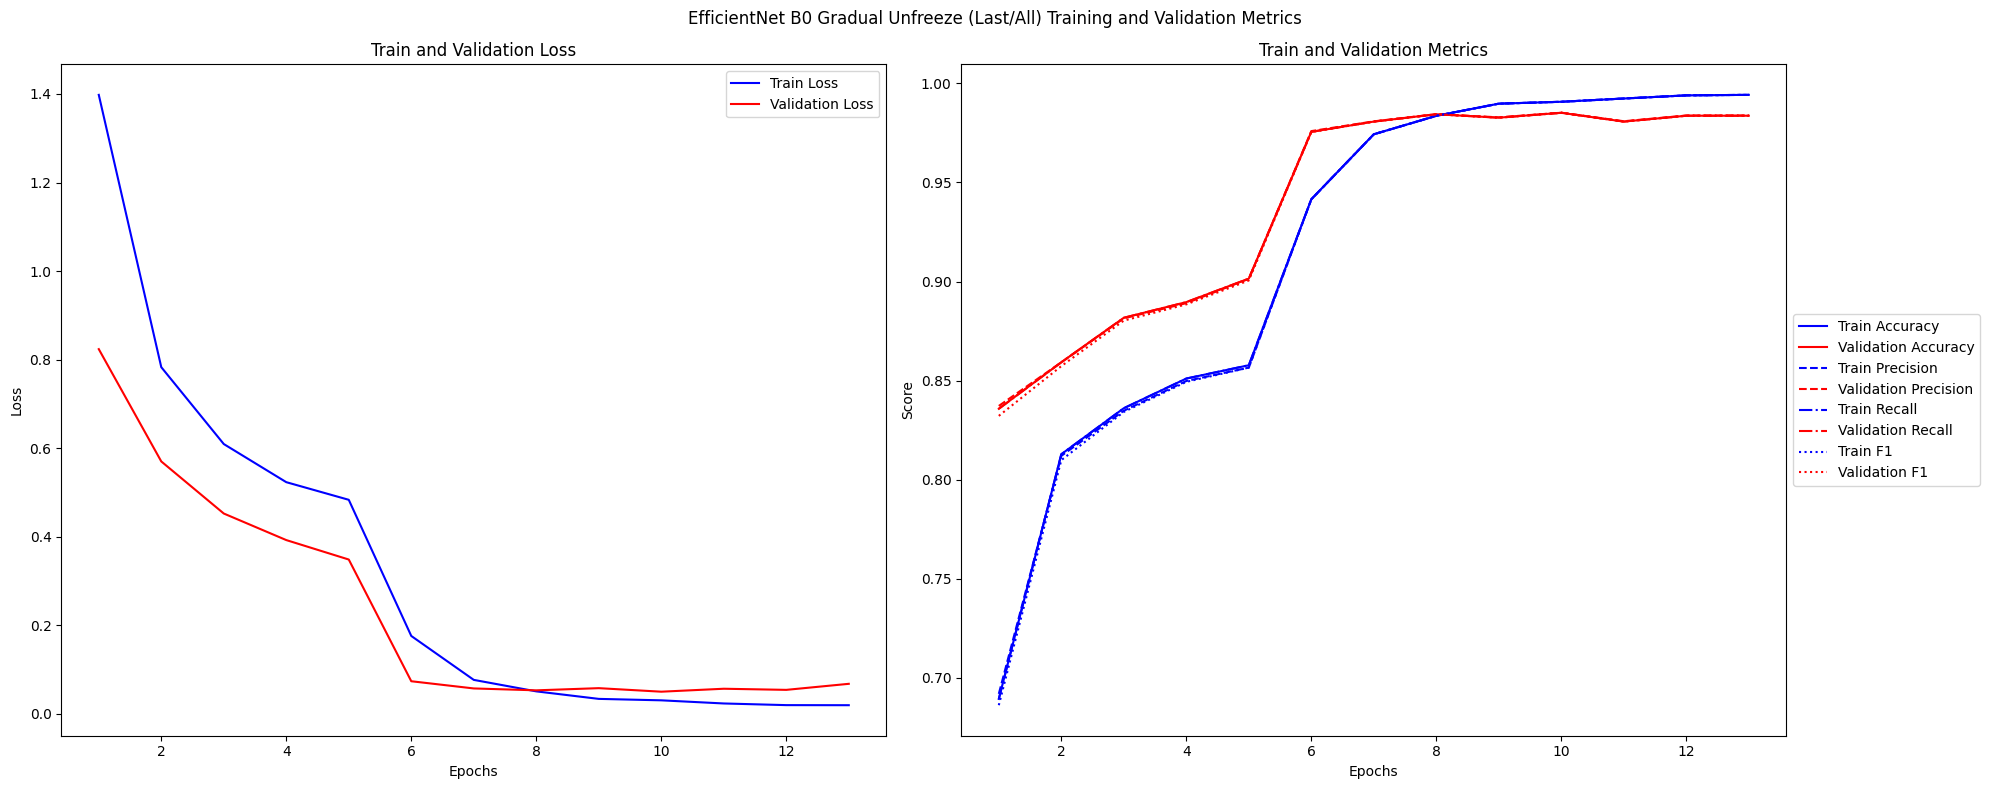

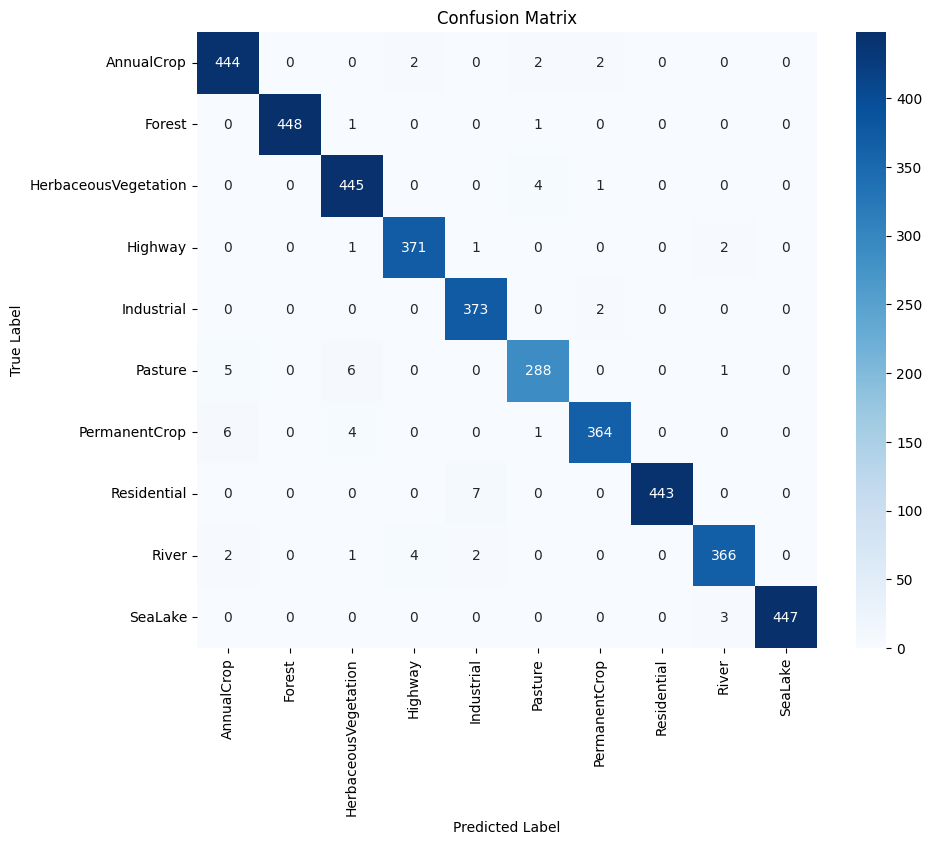

In [ ]:
efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=10)

epochs = 40

efficientnet_gradual_trainer = Trainer(
    model=efficientnet,
    dataloader=data_loaders,
    epochs=epochs,
    best_model_filename='./best_model_efficientnet_gradual.pth',
    best_model_path=f"./models",
    learning_rate=1e-4,
    gradual_unfreeze=True,
)

efficientnet_gradual_trainer.fit()
history = efficientnet_gradual_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

efficientnet_gradual_trainer.plot_metrics(title="EfficientNet B0 Gradual Unfreeze (Last/All) Training and Validation Metrics")
efficientnet_gradual_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_efficientnet_gradual_df = pd.DataFrame(efficientnet_gradual_trainer.history)
metrics_efficientnet_gradual_df.to_csv('./metrics/metrics_efficientnet_gradual.csv', index=False)

# Fine-Tuning Image Classifier - EfficientNet B0 Frozen

Using device: mps
Number of classes: 10
Using loss function: CrossEntropyLoss


Train Epoch 1/40: 100%|██████████| 591/591 [00:56<00:00, 10.54batch/s, loss=1.4] 


Epoch 1 - Train Loss: 1.3999 - Train Accuracy: 0.6854 - Train F1: 0.6836 - Train Precision: 0.6901 - Train Recall: 0.6854


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.05batch/s, loss=0.83] 


Epoch 1 - Val Loss: 0.8310 - Val Accuracy: 0.8378 - Val F1: 0.8344 - Val Precision: 0.8404 - Val Recall: 0.8378
Validation loss improved from inf to 0.8310.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 2/40: 100%|██████████| 591/591 [00:55<00:00, 10.56batch/s, loss=0.779]


Epoch 2 - Train Loss: 0.7795 - Train Accuracy: 0.8138 - Train F1: 0.8108 - Train Precision: 0.8129 - Train Recall: 0.8138


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.05batch/s, loss=0.562]


Epoch 1 - Val Loss: 0.5583 - Val Accuracy: 0.8657 - Val F1: 0.8636 - Val Precision: 0.8657 - Val Recall: 0.8657
Validation loss improved from 0.8310 to 0.5583.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 3/40: 100%|██████████| 591/591 [00:56<00:00, 10.51batch/s, loss=0.606]


Epoch 3 - Train Loss: 0.6062 - Train Accuracy: 0.8378 - Train F1: 0.8360 - Train Precision: 0.8367 - Train Recall: 0.8378


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.05batch/s, loss=0.455]


Epoch 1 - Val Loss: 0.4492 - Val Accuracy: 0.8815 - Val F1: 0.8803 - Val Precision: 0.8820 - Val Recall: 0.8815
Validation loss improved from 0.5583 to 0.4492.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 4/40: 100%|██████████| 591/591 [00:55<00:00, 10.60batch/s, loss=0.527]


Epoch 4 - Train Loss: 0.5273 - Train Accuracy: 0.8502 - Train F1: 0.8486 - Train Precision: 0.8489 - Train Recall: 0.8502


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.08batch/s, loss=0.386]


Epoch 1 - Val Loss: 0.3811 - Val Accuracy: 0.8948 - Val F1: 0.8942 - Val Precision: 0.8955 - Val Recall: 0.8948
Validation loss improved from 0.4492 to 0.3811.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 5/40: 100%|██████████| 591/591 [00:55<00:00, 10.56batch/s, loss=0.477]


Epoch 5 - Train Loss: 0.4768 - Train Accuracy: 0.8597 - Train F1: 0.8586 - Train Precision: 0.8586 - Train Recall: 0.8597


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.04batch/s, loss=0.35] 


Epoch 1 - Val Loss: 0.3439 - Val Accuracy: 0.9007 - Val F1: 0.8999 - Val Precision: 0.9003 - Val Recall: 0.9007
Validation loss improved from 0.3811 to 0.3439.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 6/40: 100%|██████████| 591/591 [00:55<00:00, 10.57batch/s, loss=0.446]


Epoch 6 - Train Loss: 0.4455 - Train Accuracy: 0.8658 - Train F1: 0.8647 - Train Precision: 0.8644 - Train Recall: 0.8658


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.03batch/s, loss=0.33] 


Epoch 1 - Val Loss: 0.3238 - Val Accuracy: 0.9052 - Val F1: 0.9044 - Val Precision: 0.9054 - Val Recall: 0.9052
Validation loss improved from 0.3439 to 0.3238.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 7/40: 100%|██████████| 591/591 [00:56<00:00, 10.55batch/s, loss=0.414]


Epoch 7 - Train Loss: 0.4140 - Train Accuracy: 0.8730 - Train F1: 0.8721 - Train Precision: 0.8720 - Train Recall: 0.8730


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.04batch/s, loss=0.319]


Epoch 1 - Val Loss: 0.3106 - Val Accuracy: 0.9064 - Val F1: 0.9053 - Val Precision: 0.9064 - Val Recall: 0.9064
Validation loss improved from 0.3238 to 0.3106.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 8/40: 100%|██████████| 591/591 [00:56<00:00, 10.52batch/s, loss=0.398]


Epoch 8 - Train Loss: 0.3977 - Train Accuracy: 0.8761 - Train F1: 0.8754 - Train Precision: 0.8752 - Train Recall: 0.8761


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.04batch/s, loss=0.304]


Epoch 1 - Val Loss: 0.2953 - Val Accuracy: 0.9109 - Val F1: 0.9101 - Val Precision: 0.9111 - Val Recall: 0.9109
Validation loss improved from 0.3106 to 0.2953.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 9/40: 100%|██████████| 591/591 [00:56<00:00, 10.55batch/s, loss=0.388]


Epoch 9 - Train Loss: 0.3883 - Train Accuracy: 0.8758 - Train F1: 0.8749 - Train Precision: 0.8748 - Train Recall: 0.8758


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.08batch/s, loss=0.283]


Epoch 1 - Val Loss: 0.2750 - Val Accuracy: 0.9151 - Val F1: 0.9147 - Val Precision: 0.9150 - Val Recall: 0.9151
Validation loss improved from 0.2953 to 0.2750.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 10/40: 100%|██████████| 591/591 [00:55<00:00, 10.56batch/s, loss=0.372]


Epoch 10 - Train Loss: 0.3723 - Train Accuracy: 0.8816 - Train F1: 0.8809 - Train Precision: 0.8807 - Train Recall: 0.8816


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.05batch/s, loss=0.281]


Epoch 1 - Val Loss: 0.2728 - Val Accuracy: 0.9160 - Val F1: 0.9153 - Val Precision: 0.9160 - Val Recall: 0.9160
Validation loss did not improve from 0.2750 to 0.2728.
Early stop counter: 1/3


Train Epoch 11/40: 100%|██████████| 591/591 [00:55<00:00, 10.62batch/s, loss=0.367]


Epoch 11 - Train Loss: 0.3666 - Train Accuracy: 0.8813 - Train F1: 0.8805 - Train Precision: 0.8802 - Train Recall: 0.8813


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.267]


Epoch 1 - Val Loss: 0.2592 - Val Accuracy: 0.9200 - Val F1: 0.9195 - Val Precision: 0.9203 - Val Recall: 0.9200
Validation loss improved from 0.2750 to 0.2592.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 12/40: 100%|██████████| 591/591 [00:55<00:00, 10.60batch/s, loss=0.346]


Epoch 12 - Train Loss: 0.3463 - Train Accuracy: 0.8908 - Train F1: 0.8903 - Train Precision: 0.8901 - Train Recall: 0.8908


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.271]


Epoch 1 - Val Loss: 0.2633 - Val Accuracy: 0.9143 - Val F1: 0.9137 - Val Precision: 0.9155 - Val Recall: 0.9143
Validation loss did not improve from 0.2592 to 0.2633.
Early stop counter: 1/3


Train Epoch 13/40: 100%|██████████| 591/591 [00:55<00:00, 10.63batch/s, loss=0.342]


Epoch 13 - Train Loss: 0.3421 - Train Accuracy: 0.8907 - Train F1: 0.8901 - Train Precision: 0.8900 - Train Recall: 0.8907


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.02batch/s, loss=0.25] 


Epoch 1 - Val Loss: 0.2429 - Val Accuracy: 0.9237 - Val F1: 0.9233 - Val Precision: 0.9239 - Val Recall: 0.9237
Validation loss improved from 0.2592 to 0.2429.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 14/40: 100%|██████████| 591/591 [00:55<00:00, 10.60batch/s, loss=0.334]


Epoch 14 - Train Loss: 0.3341 - Train Accuracy: 0.8922 - Train F1: 0.8916 - Train Precision: 0.8914 - Train Recall: 0.8922


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.247]


Epoch 1 - Val Loss: 0.2407 - Val Accuracy: 0.9227 - Val F1: 0.9223 - Val Precision: 0.9234 - Val Recall: 0.9227
Validation loss did not improve from 0.2429 to 0.2407.
Early stop counter: 1/3


Train Epoch 15/40: 100%|██████████| 591/591 [00:55<00:00, 10.62batch/s, loss=0.331]


Epoch 15 - Train Loss: 0.3314 - Train Accuracy: 0.8930 - Train F1: 0.8925 - Train Precision: 0.8924 - Train Recall: 0.8930


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s, loss=0.245]


Epoch 1 - Val Loss: 0.2373 - Val Accuracy: 0.9247 - Val F1: 0.9242 - Val Precision: 0.9243 - Val Recall: 0.9247
Validation loss improved from 0.2429 to 0.2373.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 16/40: 100%|██████████| 591/591 [00:55<00:00, 10.63batch/s, loss=0.327]


Epoch 16 - Train Loss: 0.3267 - Train Accuracy: 0.8925 - Train F1: 0.8919 - Train Precision: 0.8917 - Train Recall: 0.8925


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.05batch/s, loss=0.245]


Epoch 1 - Val Loss: 0.2368 - Val Accuracy: 0.9267 - Val F1: 0.9262 - Val Precision: 0.9263 - Val Recall: 0.9267
Validation loss did not improve from 0.2373 to 0.2368.
Early stop counter: 1/3


Train Epoch 17/40: 100%|██████████| 591/591 [01:08<00:00,  8.69batch/s, loss=0.317]


Epoch 17 - Train Loss: 0.3165 - Train Accuracy: 0.8992 - Train F1: 0.8987 - Train Precision: 0.8986 - Train Recall: 0.8992


Val Epoch 1/40: 100%|██████████| 127/127 [00:32<00:00,  3.88batch/s, loss=0.238]


Epoch 1 - Val Loss: 0.2300 - Val Accuracy: 0.9254 - Val F1: 0.9249 - Val Precision: 0.9251 - Val Recall: 0.9254
Validation loss improved from 0.2373 to 0.2300.
Best model saved to ./Sentinel-2_Land_Cover_Dataset/./best_model_efficientnet_frozen.pth


Train Epoch 18/40: 100%|██████████| 591/591 [00:59<00:00, 10.00batch/s, loss=0.312]


Epoch 18 - Train Loss: 0.3123 - Train Accuracy: 0.8973 - Train F1: 0.8968 - Train Precision: 0.8966 - Train Recall: 0.8973


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.08batch/s, loss=0.236]


Epoch 1 - Val Loss: 0.2287 - Val Accuracy: 0.9272 - Val F1: 0.9267 - Val Precision: 0.9273 - Val Recall: 0.9272
Validation loss did not improve from 0.2300 to 0.2287.
Early stop counter: 1/3


Train Epoch 19/40: 100%|██████████| 591/591 [00:55<00:00, 10.65batch/s, loss=0.312]


Epoch 19 - Train Loss: 0.3123 - Train Accuracy: 0.8973 - Train F1: 0.8967 - Train Precision: 0.8965 - Train Recall: 0.8973


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.07batch/s, loss=0.237]


Epoch 1 - Val Loss: 0.2297 - Val Accuracy: 0.9281 - Val F1: 0.9274 - Val Precision: 0.9281 - Val Recall: 0.9281
Validation loss did not improve from 0.2300 to 0.2297.
Early stop counter: 2/3


Train Epoch 20/40: 100%|██████████| 591/591 [00:55<00:00, 10.59batch/s, loss=0.304]


Epoch 20 - Train Loss: 0.3042 - Train Accuracy: 0.9010 - Train F1: 0.9004 - Train Precision: 0.9002 - Train Recall: 0.9010


Val Epoch 1/40: 100%|██████████| 127/127 [00:31<00:00,  4.05batch/s, loss=0.242]


Epoch 1 - Val Loss: 0.2331 - Val Accuracy: 0.9240 - Val F1: 0.9234 - Val Precision: 0.9239 - Val Recall: 0.9240
Validation loss did not improve from 0.2300 to 0.2331.
Early stop counter: 3/3
Early stopping triggered at epoch 20.


Test Epoch 1/40: 100%|██████████| 127/127 [00:30<00:00,  4.10batch/s, loss=0.255]

Test loss: 0.24824123479440574 accuracy: 0.9185185185185185 precision: 0.9192047957662618 recall: 0.9185185185185185 f1: 0.9182632512816966


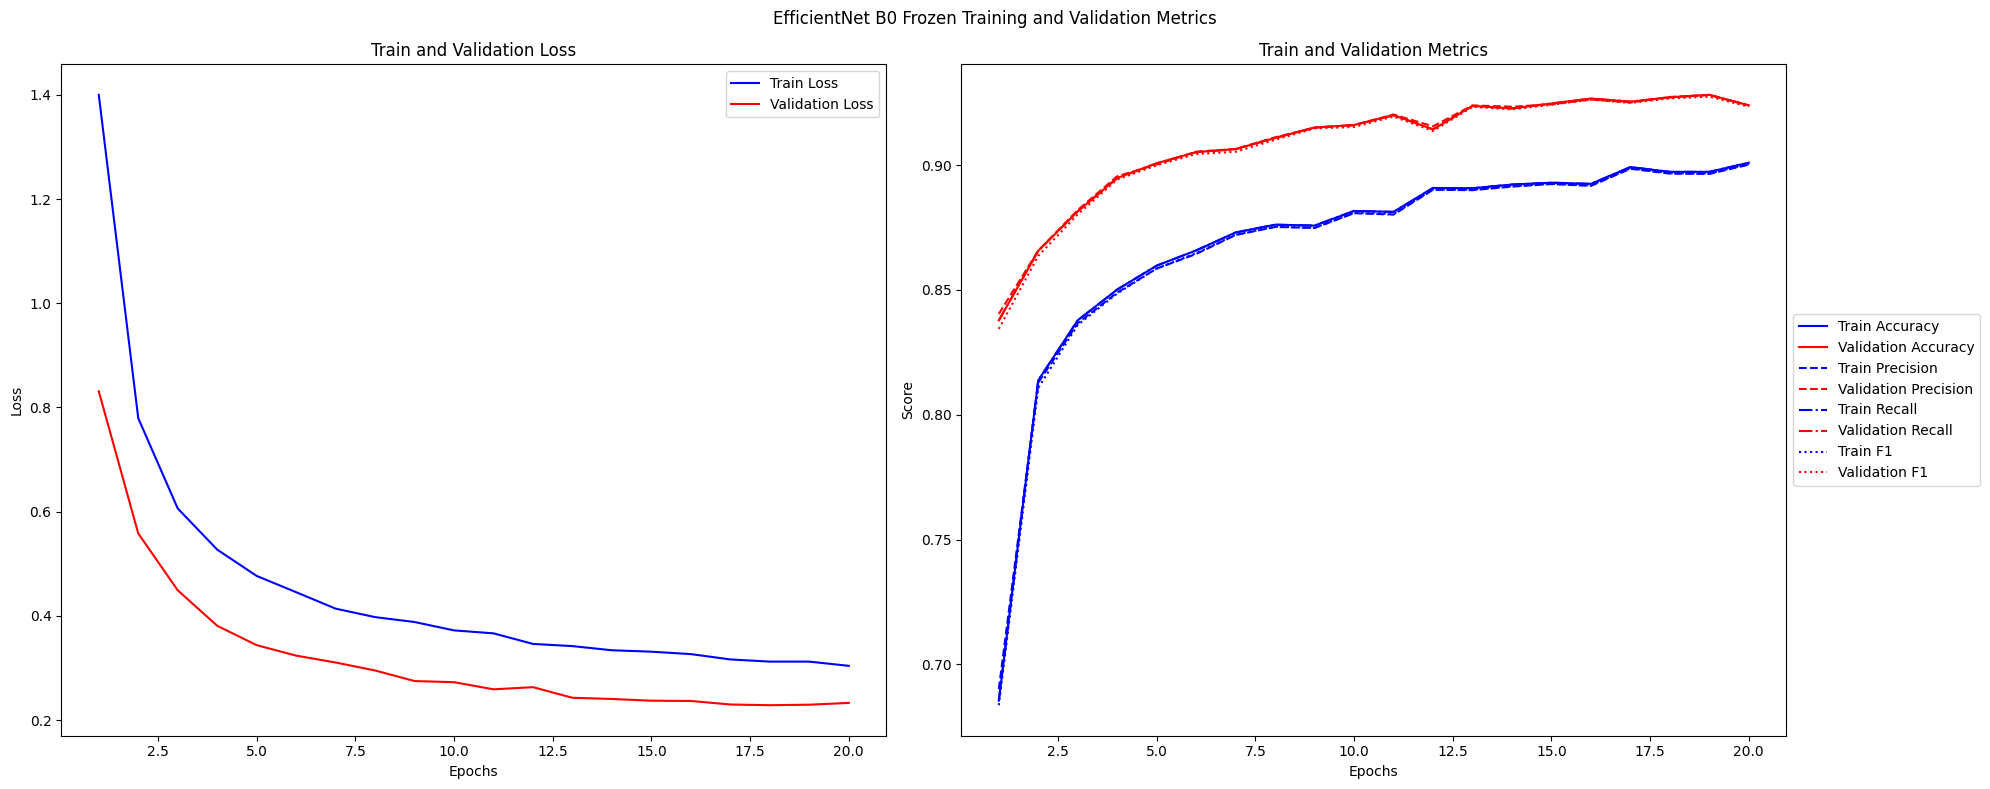

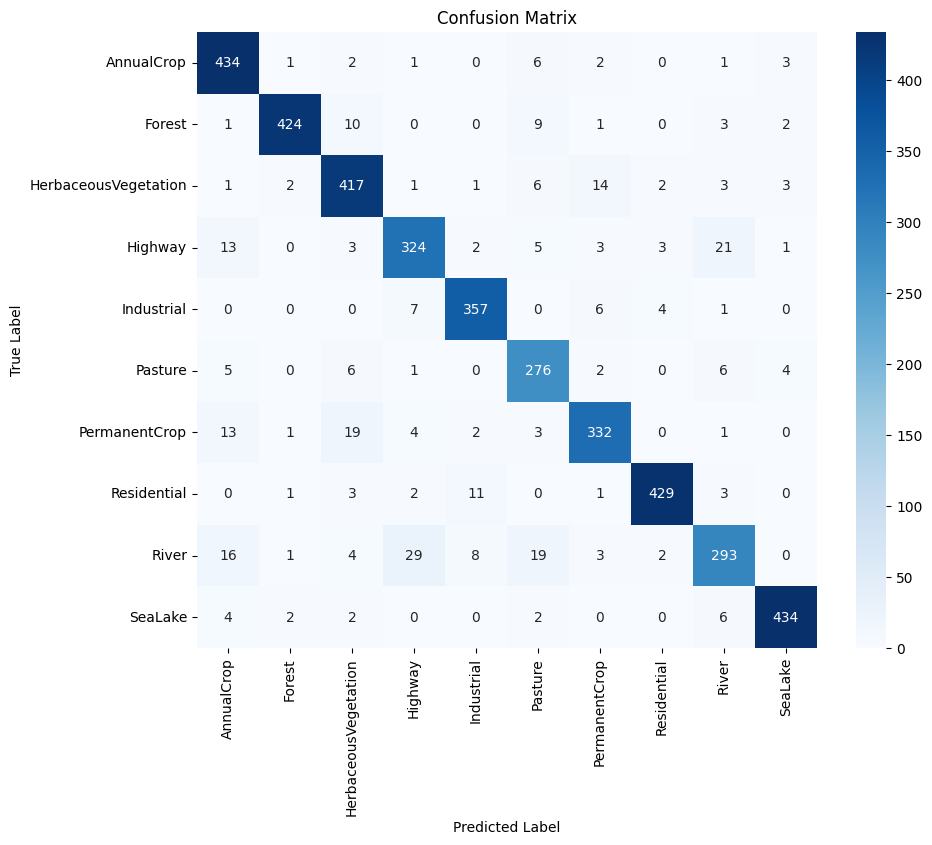

In [ ]:
efficientnet_frozen = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet_frozen.classifier[1] = nn.Linear(in_features=1280, out_features=10)

epochs = 40

# Freeze all layers except the last one
for param in efficientnet_frozen.parameters():
    param.requires_grad = False
for param in efficientnet_frozen.classifier.parameters():
    param.requires_grad = True
    
# Set the optimizer to only update the last layer
efficientnet_frozen_optimizer = torch.optim.AdamW(efficientnet_frozen.classifier.parameters(), lr=1e-4, weight_decay=1e-2)

epochs = 40

efficientnet_frozen_trainer = Trainer(
    model=efficientnet_frozen,
    dataloader=data_loaders,
    epochs=epochs,
    best_model_filename='./best_model_efficientnet_frozen.pth',
    best_model_path=f"./models",
    optimizer=efficientnet_frozen_optimizer
)

efficientnet_frozen_trainer.fit()
history = efficientnet_frozen_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

efficientnet_frozen_trainer.plot_metrics(title="EfficientNet B0 Frozen Training and Validation Metrics")
efficientnet_frozen_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_efficientnet_frozen_df = pd.DataFrame(efficientnet_frozen_trainer.history)
metrics_efficientnet_frozen_df.to_csv('./metrics/metrics_efficientnet_frozen.csv', index=False)